# **Natural Language Processing Coursework - 23COP509**
# **Student ID : F316169**

# **Important Note:**
#### When converting Jupyter Notebooks to HTML using nbconvert, interactive elements like ipywidgets or Plotly figures aren't displaying in the HTML output. This is the shortcoming of the nbconvert since they won't be able to display interactively in a static HTML generated by nbconvert.

#### Please refer the course work .ipynb file submitted on learn. All the marking heading are correctly labeled, you can easily navigate into it.




# **Abstract**:
#### The coursework revolves around implementing an information retrieval, clustering, and summarization tool in Python. We start by getting a bunch of reviews about jewelry and getting them ready for analysis. Then, we build special models to help us find the most relevant reviews, like Latent Semantic Indexing (LSI) and neural models. We also make a tool that lets us easily search and see the results. After that, we group similar search results together, figure out the best way to do this, and check how well our models work. Finally, we summarize what people are talking about in these groups of results and test different ways of summarizing. We also add some extra features to help with summarization.

# TASK 1:
## Pre-process the dataset. Develop code to clean and pre-process the dataset. Look at the dictionary to ensure you cleaned the data well. (5 Marks)

In [68]:
from google.colab import drive  # Mounting Google Drive to Colab Notebook
drive.mount("/content/drive")
!ls "/content/drive/My Drive/Colab Notebooks/COP509cw/Datasets/"
Data_path = "/content/drive/My Drive/Colab Notebooks/COP509cw/Datasets/"   #In the Dataset folder, set the filename to the path of the CSV file.
filename=str('/content/drive/My Drive/Colab Notebooks/COP509cw/Datasets/JewelleryReviewsLSA.csv')

# Importing libraries #
import pandas as pd
import random
from pandas import DataFrame
from matplotlib import pyplot
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from os import listdir
from collections import Counter
import numpy as np
from numpy import array
import warnings
from numpy import argsort
from string import punctuation
from collections import Counter
import csv
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
warnings.filterwarnings("ignore")
from sklearn.metrics.pairwise import cosine_similarity
from IPython.display import display, HTML


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
JewelleryReviewsLSA.csv		     JewelleryReviewsSummarisationTargets.csv
JewelleryReviewsQueryRelevantID.csv


In [69]:
# Import the file using pandas
df = pd.read_csv(filename)
print(df)

        ID    Reviews  Ratings
0    32767  i expe...        1
1    15959  I orde...        1
2    43515  This r...        1
3    46347  This r...        1
4    30720  This i...        1
..     ...        ...      ...
195  44489  I just...        5
196  44490  These ...        5
197  56830  I real...        3
198  56830  I real...        3
199  56830  I real...        3

[200 rows x 3 columns]


In [70]:
df["Reviews"] = df["Reviews"].str.lower()
df.head()

,ID,Reviews,Ratings
0,32767,i expe...,1
1,15959,i orde...,1
2,43515,this r...,1
3,46347,this r...,1
4,30720,this i...,1


In [71]:
# removing the punctuation to clean up the review
import string

# defining punctuation characters
punctuations = string.punctuation

def removing_punctuation(document):
    """function to remove the punctuation"""
    # using translate method to remove punctuation
    return document.translate(str.maketrans('', '', punctuations))

# applying the function to remove punctuation from the "Reviews" column in dataframe
df["Reviews"] = df["Reviews"].apply(lambda doc: removing_punctuation(doc))
# displaying the first few rows of the dataframe after punctuation removal
df.head()


,ID,Reviews,Ratings
0,32767,i expe...,1
1,15959,i orde...,1
2,43515,this r...,1
3,46347,this r...,1
4,30720,this i...,1


In [72]:
# This code is mostly copied from the Lab Tutorials, in which I added the lementatization since adding it imporving the performance of the model.

# Importing necessary libraries and tools
from nltk.stem import WordNetLemmatizer
import nltk
from nltk.corpus import stopwords
from string import punctuation

# Initializing WordNetLemmatizer
wordnet_lemmatizer = WordNetLemmatizer()

# Downloading NLTK resources
nltk.download('stopwords')
nltk.download('wordnet')

def add_doc_to_vocab(file_path, vocabulary):
    """
    Add document tokens to vocabulary.

    Parameters:
    file_path (str): Path to the document file.
    vocabulary (set): Vocabulary to update with document tokens.
    """
    # Loading document
    document = load_doc(file_path)
    # Cleaning document
    tokens = clean_doc(document)
    # Updating vocabulary counts
    vocabulary.update(tokens)

def load_doc(file_path):
    """
    Load document from file.

    Parameters:
    file_path (str): Path to the document file.

    Returns:
    str: Contents of the document.
    """
    # Opening the file in read mode
    file_handle = open(file_path, 'r')
    # Reading the entire content
    text_content = file_handle.read()
    # Closing the file
    file_handle.close()
    return text_content

def save_list(text_lines, file_path):
    """
    Save list of text lines to file.

    Parameters:
    text_lines (list): List of text lines.
    file_path (str): Path to the file to save the text lines.
    """
    # Converting lines to a single string
    text_data = '\n'.join(text_lines)
    # Opening file for writing
    file_handle = open(file_path, 'w')
    # Writing text to file
    file_handle.write(text_data)
    # Closing the file
    file_handle.close()

def load_doc_lines(file_path):
    """
    Load document into memory as lines.

    Parameters:
    file_path (str): Path to the document file.

    Returns:
    list: List of lines in the document.
    """
    file_handle = open(file_path, 'rt')
    text_lines = list()
    # Reading all text as lines
    while 1:
        line = file_handle.readline()
        if not line:
            break
        text_lines.append(line.strip("\n"))
    # Closing the file
    file_handle.close()
    return text_lines

def clean_doc(document):
    """
    Clean document and tokenize it.

    Parameters:
    document (str): Input document to be cleaned.

    Returns:
    list: List of cleaned tokens.
    """
    # Splitting into tokens by white space
    tokenized = document.split()
    # Converting to lower case
    tokenized = [word.lower() for word in tokenized]
    # Lemmatizing tokens
    tokenized = [wordnet_lemmatizer.lemmatize(word) for word in tokenized]
    # Stemming of words
    from nltk.stem.porter import PorterStemmer
    porter = PorterStemmer()
    tokenized = [porter.stem(word) for word in tokenized]
    # Removing punctuation from each token
    table = str.maketrans('', '', punctuation)
    tokenized = [w.translate(table) for w in tokenized]
    # Removing remaining tokens that are not alphabetic
    tokenized = [word for word in tokenized if word.isalpha()]
    # Filtering out stop words
    stop_words = set(stopwords.words('english'))
    tokenized = [w for w in tokenized if not w in stop_words]
    # Filtering out short tokens
    tokenized = [word for word in tokenized if len(word) > 1]
    return tokenized

def doc_to_line(doc):
    """
    Convert document into line of tokens.

    Parameters:
    doc (str): Input document to be converted.

    Returns:
    str: Line of tokens.
    """
    # Cleaning the document
    tokens = clean_doc(doc)
    return ' '.join(tokens)

def process_docs(text_files):
    """
    Process all documents in a directory.

    Parameters:
    text_files (list): List of document files.

    Returns:
    list: List of processed document lines.
    """
    lines = list()
    # Iterating through all files in the folder
    for document in text_files:
        line = doc_to_line(document)
        # Adding cleaned document to list
        lines.append(line)
    return lines


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# TASK 2:
## Latent Semantic Indexing (LSI)
### 2(a). Develop a Latent Semantic Indexing (LSI) model. Develop functionality such that for each query, the LSI model retrieves the top 10 most similar reviews from the dataset. (5 marks)

In [73]:
# This code is adapted from the Lab Tutorials, changes were made to fulfill the requirements.

def prepare_data(train_docs, mode, vocab):
    """
    Prepare words encoding of documents using CountVectorizer and TfidfTransformer.

    Parameters:
    train_docs (list): List of document lines for training.
    mode (str): Mode for encoding ('tfidf' or other).
    vocab (list): Vocabulary list.

    Returns:
    scipy.sparse.csr_matrix: Encoded training data.
    """
    # Encode training data set
    vectorizer = CountVectorizer(vocabulary=vocab)  # Initialize CountVectorizer with provided vocabulary
    transformer = TfidfTransformer(norm='l2')  # Initialize TfidfTransformer with L2 normalization
    Xtrain = transformer.fit_transform(vectorizer.fit_transform(train_docs))  # Fit CountVectorizer and TfidfTransformer to train_docs
    return Xtrain

# Loading the dataset
Jewellery_train_lines = load_doc_lines(Data_path + 'JewelleryReviewsLSA.csv')  # Load document lines from dataset

train_docs = process_docs(Jewellery_train_lines)  # Process document lines

# Generate vocabulary
vocab = []
for doc in train_docs:
    tokens = doc.split()
    for word in tokens:
        if word not in vocab:
            vocab.append(word)

# Initially, using the prepare_data function using the 'tfidf' method and the provided vocabulary to prepare the training data.
Xtrain = prepare_data(train_docs, 'tfidf', vocab)  # Prepare training data with TF-IDF encoding and provided vocabulary

# Making an instance of the 50-component TruncatedSVD model and fit it to the training set of data.
trunc_SVD_model = TruncatedSVD(n_components=50)  # Initialize TruncatedSVD model with 50 components
approx_Xtrain = trunc_SVD_model.fit_transform(Xtrain)  # Fit TruncatedSVD to the encoded training data

# Print the shape of the approximated Xtrain
print("Approximated Xtrain shape: " + str(approx_Xtrain.shape))  # Print the shape of the approximated training data


Approximated Xtrain shape: (201, 50)


In [74]:
# This code is adapted from the Lab Tutorials, changes were made to fulfill the requirements.

def preprocess_review_query(review, mode, vocab):
    """
    Preprocess a review query by cleaning, encoding, and transforming it.

    Parameters:
    review (str): Review query to preprocess.
    mode (str): Mode for encoding ('tfidf' or other).
    vocab (list): Vocabulary list.

    Returns:
    scipy.sparse.csr_matrix: Encoded and transformed review query.
    """
    # Clean review query
    tokens = clean_doc(review)
    # Convert tokens to line
    line = ' '.join(tokens)
    # Encode review query
    vectorizer = CountVectorizer(vocabulary=vocab)
    transformer = TfidfTransformer(norm='l2')
    encoded = transformer.fit_transform(vectorizer.fit_transform([line]))
    return encoded

Querys = ['The ring is a great gift. My friend loves it',
          'horrible bad quality bracelet',
          'arrived promptly and happy with the seller',
          'wear it with casual wear',
          'i expected better quality. i will return this item',
          'looks beautiful. The design is pretty. pefect and color is light',
          'This ring looks nothing like the picture. the diamonds are small and not very noticeable',
          'braclet looked just like its picture and is nice quality sterling silver.',
]

top_reviews_indices_list = [];

# Display the query results
heading = "<p style='font-size:30px; text-align:center;'>Querywise: Top 10 Similar Reviews </p>"
display(HTML(heading))

j = 1
for query in Querys:
    # Preprocess review query
    encoded_query = preprocess_review_query(query, 'tfidf', vocab)
    # Transform query using TruncatedSVD model
    transformed_query = trunc_SVD_model.transform(encoded_query)
    # Calculate cosine similarity between transformed query and encoded training data
    similarities = cosine_similarity(approx_Xtrain, transformed_query)

    Top_n_reviews = 10
    # Sort the similarities indexes to get the top 10
    selected_indexes = np.argsort(similarities.flat)[::-1]

    print('\n' + 'Query ' + str(j) + ': ' + query + '\n')

    top_review_indexes = [];

    # Looping 10 times and printing the top 10 best reviews
    for i in range(Top_n_reviews):
        top_review_indexes.append(selected_indexes[i])
        print("Reviews ID: " + str(df.iloc[selected_indexes[i] - 1]['ID']))
        print(str(df.iloc[selected_indexes[i]+1]['Reviews']))
    print('\n-------------------------------------------')
    top_reviews_indices_list.append(top_review_indexes)
    j = j+1

# top_reviews_indices_list



Query 1: The ring is a great gift. My friend loves it

Reviews ID: 58481
i love my birthstone and i wanted a piece of jewelry that symbolized the simple purity of the blue topaz this ring did that for me as a gift to myself for my birthday this year it was definitely a great gift and a welcomed addition to my collection
Reviews ID: 2033
this ring has such a good sparkle and it looks like a ring that should cost 10x the amount makes a great gift for someone on a budget my girlfriend loves it
Reviews ID: 17273
very disappointed in the appearance and quality of the bracelet and its definitely not worth 4500  not even close
Reviews ID: 41876
ive owned several claddagh rings over the years and lost my last one i received this one as a gift recently and i truly love it its sturdy and the design is crisp i can easily recommend this one as a lovely ring
Reviews ID: 49525
my neice loves her birth stone so i got it for her for a christmas gifti also love it also great
Reviews ID: 17309
my mothe

In [75]:
# The following method represents my original idea and code, since the task require this to be added.


def convert_index_to_review_id(top_reviews_indices_list, dataframe):
    """
    Convert index values to their corresponding review IDs in a pandas DataFrame.

    Parameters:
    top_reviews_indices_list (list): 2D list containing index values.
    dataframe (pd.DataFrame): Pandas DataFrame containing review IDs.

    Returns:
    list: 2D list of review IDs corresponding to the index values.

    """
    review_ids_list = []

    for query_index_list in top_reviews_indices_list:
        query_review_ids = []

        for index_value in query_index_list:
            # Retrieve the ID corresponding to the index value and add it to the query_review_ids list
            query_review_ids.append(dataframe["ID"][abs(index_value - 1)])  # -1 is used to match the correct ID with the index

        review_ids_list.append(query_review_ids)  # Add the query_review_ids list to the review_ids_list

    return review_ids_list

query_review_ids_list = convert_index_to_review_id(top_reviews_indices_list, df)
query_review_ids_list


[[58481, 2033, 17273, 41876, 49525, 17309, 45278, 48779, 36164, 56494],
 [25299, 7432, 55017, 57123, 40871, 2114, 1816, 22058, 642, 51907],
 [9726, 41889, 2780, 4375, 10758, 31657, 22408, 13373, 54748, 33251],
 [30640, 53660, 28648, 37486, 12483, 2134, 2131, 54548, 51474, 26535],
 [13373, 33571, 265, 17607, 17944, 41459, 45856, 38305, 36677, 4375],
 [46500, 43945, 27474, 45860, 41319, 943, 52375, 39932, 10612, 37794],
 [209, 47345, 216, 44358, 36165, 32767, 42026, 33632, 51356, 3494],
 [642, 53409, 45518, 10642, 735, 3494, 37794, 943, 10037, 38637]]

In [76]:
# Define the file path to the CSV file containing jewellery reviews and relevant IDs
file_path = Data_path + "JewelleryReviewsQueryRelevantID.csv"

# Read the CSV file into a pandas DataFrame
df_reviews = pd.read_csv(file_path)

# Display the first 10 rows of the DataFrame
df_reviews.head(10)


,Query1,Query2,Query3,Query4,Query5,Query6,Query7,Query8,Unnamed: 8,Query1Text,Query2Text,Query3Text,Query4Text,Query5Text,Query6Text,Query7Text,Query8Text
0,36164,57123.00,33251.00,40373.00,13373.00,45860.00,209.00,642.00,NaN,The ri...,horrib...,arrive...,wear i...,i expe...,looks ...,This r...,bracle...
1,58481,25299.00,17304.00,28648.00,17607.00,46500.00,28542.00,10642.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,26246,55017.00,50019.00,37486.00,41459.00,27474.00,216.00,37794.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2033,7432.00,27679.00,30640.00,54748.00,43945.00,47345.00,45518.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,48779,2114.00,6158.00,2131.00,33571.00,52837.00,11356.00,3494.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,34523,40871.00,22408.00,19852.00,NaN,12358.00,33632.00,735.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,9726,NaN,29722.00,2134.00,NaN,41319.00,38637.00,10037.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,56494,NaN,36677.00,36585.00,NaN,39932.00,7110.00,41872.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,49525,NaN,2780.00,26535.00,NaN,45146.00,6649.00,28542.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,45278,NaN,17944.00,51474.00,NaN,50197.00,51356.00,53409.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [77]:
# The following method represents my original idea and code, since the task require this to be added.

import pandas as pd
import math

# Get the column indices for 'Query1' to 'Query8'
query_columns_indices = [df_reviews.columns.get_loc(f'Query{i}') for i in range(1, 9)]

# Extract values from 'Query1' to 'Query8' and put them in a list
query_values_list = df_reviews.iloc[:, query_columns_indices].values.T.tolist()

# Convert float elements to integers and handle NaN values
query_values_list = [[int(x) for x in inner if not math.isnan(x)] for inner in query_values_list]

# Print the resulting list
print(query_values_list)


[[36164, 58481, 26246, 2033, 48779, 34523, 9726, 56494, 49525, 45278, 35694, 41876, 17309, 11135, 17273, 11247], [57123, 25299, 55017, 7432, 2114, 40871], [33251, 17304, 50019, 27679, 6158, 22408, 29722, 36677, 2780, 17944, 19944, 31657, 52867, 49216], [40373, 28648, 37486, 30640, 2131, 19852, 2134, 36585, 26535, 51474, 21070, 56330, 53660, 44126], [13373, 17607, 41459, 54748, 33571], [45860, 46500, 27474, 43945, 52837, 12358, 41319, 39932, 45146, 50197, 8341, 52375], [209, 28542, 216, 47345, 11356, 33632, 38637, 7110, 6649, 51356, 44358, 36165, 943, 37864], [642, 10642, 37794, 45518, 3494, 735, 10037, 41872, 28542, 53409, 56865, 44489, 44490]]


In [78]:
# The following method represents my original idea and code, since the task require this to be added.

def calculate_precision(querys, top_indexes_item, relevant_items):
    """
    Computes the precision score for a given set of query results.

    Parameters:
        querys (list): A list containing each query.
        top_indexes_item (list): A list of top indexes for each query.
        relevant_items (list): The list of relevant items for each query.

    Returns:
        float: The precision score expressed as a percentage.
    """
    recall_counts = []

    # Go through each query
    for query_index in range(len(querys)):
        cnt = 0

        # Loop through the top indexes for each query
        for index in range(len(top_indexes_item[query_index])):
            # Check if the retrieved item at the index is among the relevant items for the query
            if top_indexes_item[query_index][index] in relevant_items[query_index]:
                # If it is, increase the count
                cnt += 1

        # Add the count to the recall list for the current query
        recall_counts.append(cnt)

    # Calculate the total sum of recall values across all queries
    total_recall = sum(recall_counts)

    # Compute the precision score as a percentage
    precision_score = (total_recall / (len(querys) * 10)) * 100

    return precision_score

# Calculate precision score
score = calculate_precision(Querys, query_review_ids_list, query_values_list)
score


67.5

### 2(b) Empirically tune your LSI model (weighting scheme and SVD dimensions)(5 marks).

In [143]:
# This code is adapted from the Lab Tutorials, changes were made to fulfill the requirements.

def evaluate_lsi_model(train_docs, weighting_scheme, vocab):
    """
    Evaluate an LSI model by transforming the training data using a specified weighting scheme.

    Parameters:
        train_docs (list): List of document lines for training.
        weighting_scheme (str): Weighting scheme for vectorization ("binary", "count", or "tfidf").
        vocab (list): Vocabulary list.

    Returns:
        scipy.sparse.csr_matrix: Transformed training data.

    Raises:
        ValueError: If an invalid weighting scheme is provided.
    """
    transformer = TfidfTransformer(norm='l2')

    # Choose the appropriate vectorizer based on the weighting scheme
    if weighting_scheme == "binary":
        vectorizer = CountVectorizer(binary=True, vocabulary=vocab)
    elif weighting_scheme == "count":
        vectorizer = CountVectorizer(vocabulary=vocab)
    elif weighting_scheme == "tfidf":
        vectorizer = TfidfVectorizer(vocabulary=vocab)
    else:
        raise ValueError("Invalid weighting scheme.")

    # Transform the data using the chosen vectorizer
    Xtrain = transformer.fit_transform(vectorizer.fit_transform(train_docs))

    return Xtrain


In [150]:
# The following method represents my original idea and code, since the task require this to be added, used ChapGPT for the syntax part.

components_array = np.arange(10, 201, 10)
weights = ["binary", "count", "tfidf"]  # Different Weight to evaluate results

# Create an empty DataFrame to store scores
score_df = pd.DataFrame(columns=weights)

# Iterate over different numbers of components
for n_comp_index in range(len(components_array)):
    # Iterate over different weighting schemes
    for weighting_index in range(len(weights)):

        # Prepare data with the chosen weighting scheme
        X_train_data = evaluate_lsi_model(train_docs, weights[weighting_index], vocab)

        # Initialize TruncatedSVD model with the current number of components
        truncated_SVD_model = TruncatedSVD(n_components=components_array[n_comp_index])

        # Fit and transform X_train_data
        approx_X_train_data = truncated_SVD_model.fit_transform(X_train_data)

        # Initialize a list to store top indexes for each query
        index_temporary = []

        # Iterate over each query
        for query_val in Querys:
            # Retrieve, transform, and calculate similarity for the query
            encoded_query = preprocess_review_query(query_val, 'tfidf', vocab)
            transformed_query = truncated_SVD_model.transform(encoded_query)
            similarities = cosine_similarity(approx_X_train_data, transformed_query)

            # Take only top 10 reviews
            top_n_reviews = 10

            # Sort and select top 10 indexes
            selected_indexes = np.argsort(similarities.flat)[::-1][:top_n_reviews]
            index_temporary.append(selected_indexes)

        # Convert index to review ID
        query_review_ids_list = convert_index_to_review_id(index_temporary, df)

        # Calculate precision score
        score = calculate_precision(Querys, query_review_ids_list, query_values_list)

        # Store the score in the DataFrame
        score_df.loc[components_array[n_comp_index], weights[weighting_index]] = score

# Set display options for pandas
pd.set_option('display.float_format', lambda x: '%.2f' % x)

# Print the DataFrame
score_df


,binary,count,tfidf
10,48.75,67.50,55.00
20,66.25,66.25,60.00
30,68.75,71.25,67.50
40,73.75,70.00,66.25
50,65.00,66.25,66.25
60,67.50,65.00,65.00
70,65.00,65.00,65.00
80,65.00,62.50,66.25
90,67.50,62.50,61.25
100,63.75,62.50,61.25


In [151]:
# Find the maximum value and its indices in the DataFrame
max_value = score_df.values.max()
max_index = score_df.values.argmax()

# Get the row and column names using the indices
row_index, col_index = divmod(max_index, score_df.shape[1])
row_component = score_df.index[row_index]
col_weight = score_df.columns[col_index]

# Print the result
print(f"Highest Precision: {max_value}")
print(f"Number of Components: {row_component}")
print(f"Weights Mode: {col_weight}")

# Store the best LSI model precision score
lsi_model_best = max_value


Highest Precision: 73.75
Number of Components: 40
Weights Mode: binary


**Observation:**

We tried out different methods, we found that the best precision we got was 73.75%. We achieved this when we set a certain parameter called "N_components" to 40 and used a method called 'binary' for weighing. The second-best precision was slightly lower at 71.25%, and we got that when N_components was set to 30 and we used count weighing. It seems that the best results tend to happen when we use N_components between 30 and 40. These result may slightly vary on running the code again.

### 2(c) Present the results using tables and graphs. Provide brief remarks on your observations. (5 marks).

In [82]:
# The following method represents my original idea and code, since the task require this to be added.

def ConvertIndexesToID(IndexList, dataframe):
    """
    Convert index values to corresponding review IDs from a pandas DataFrame.

    Parameters:
        IndexList (list): List of index values.
        dataframe (pd.DataFrame): Pandas DataFrame containing the IDs.

    Returns:
        list: List of corresponding review IDs.
    """
    reviewIdList = []
    for i in range(len(IndexList)):
        reviewIdList.append(dataframe["ID"][abs((IndexList[i]-1))])
    return reviewIdList


Recall@1~10:  [0.06 0.12 0.19 0.25 0.31 0.38 0.44 0.5  0.56 0.62]
Precision@1~10:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
F1measure@1~10:  [0.12 0.22 0.32 0.4  0.48 0.55 0.61 0.67 0.72 0.77]


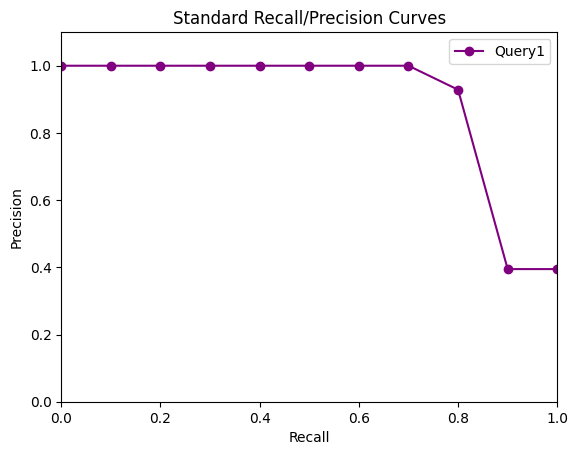

Recall@1~10:  [0.17 0.33 0.5  0.67 0.83 1.   1.   1.   1.   1.  ]
Precision@1~10:  [1.   1.   1.   1.   1.   1.   0.86 0.75 0.67 0.6 ]
F1measure@1~10:  [0.29 0.5  0.67 0.8  0.91 1.   0.92 0.86 0.8  0.75]


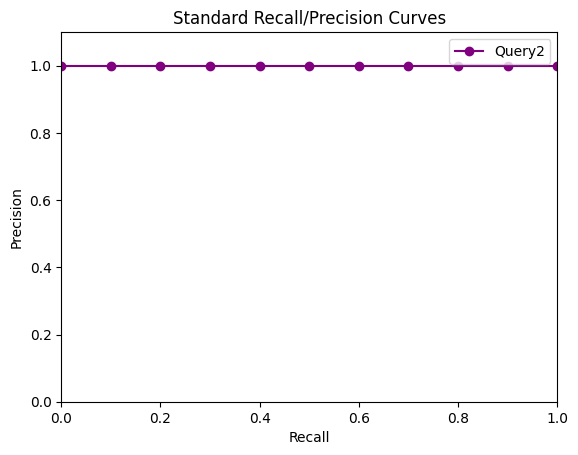

Recall@1~10:  [0.   0.   0.   0.07 0.14 0.14 0.21 0.29 0.29 0.29]
Precision@1~10:  [0.   0.   0.   0.25 0.4  0.33 0.43 0.5  0.44 0.4 ]
F1measure@1~10:  [0.   0.   0.   0.11 0.21 0.2  0.29 0.36 0.35 0.33]


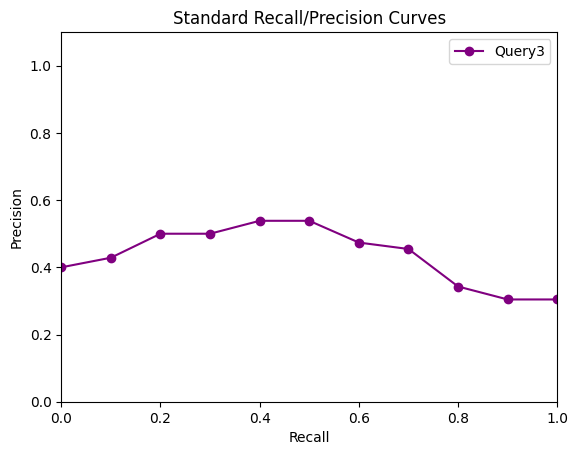

Recall@1~10:  [0.07 0.14 0.21 0.21 0.29 0.36 0.43 0.5  0.57 0.64]
Precision@1~10:  [1.   1.   1.   0.75 0.8  0.83 0.86 0.88 0.89 0.9 ]
F1measure@1~10:  [0.13 0.25 0.35 0.33 0.42 0.5  0.57 0.64 0.7  0.75]


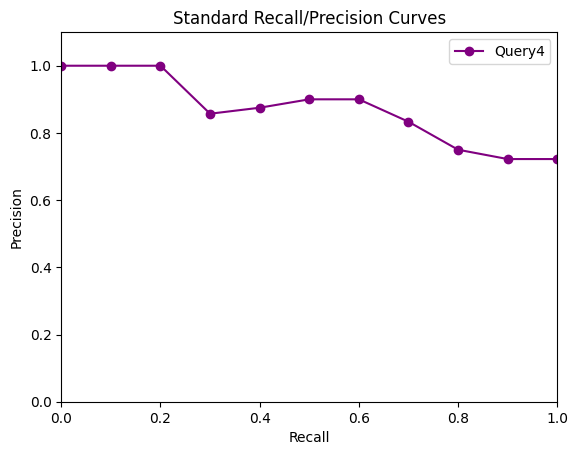

Recall@1~10:  [0.2 0.2 0.2 0.4 0.4 0.6 0.6 0.6 0.6 0.6]
Precision@1~10:  [1.   0.5  0.33 0.5  0.4  0.5  0.43 0.38 0.33 0.3 ]
F1measure@1~10:  [0.33 0.29 0.25 0.44 0.4  0.55 0.5  0.46 0.43 0.4 ]


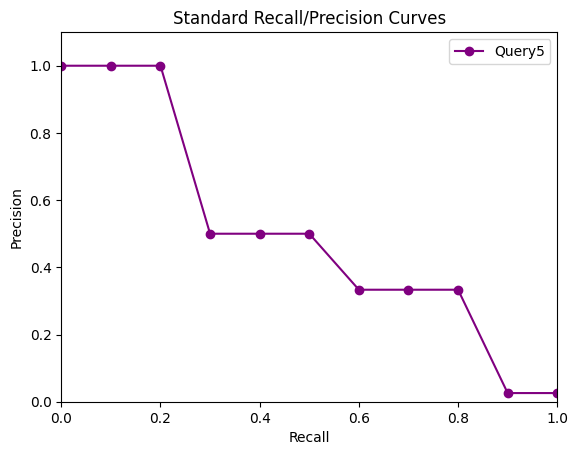

Recall@1~10:  [0.08 0.17 0.17 0.25 0.33 0.42 0.5  0.58 0.67 0.75]
Precision@1~10:  [1.   1.   0.67 0.75 0.8  0.83 0.86 0.88 0.89 0.9 ]
F1measure@1~10:  [0.15 0.29 0.27 0.38 0.47 0.56 0.63 0.7  0.76 0.82]


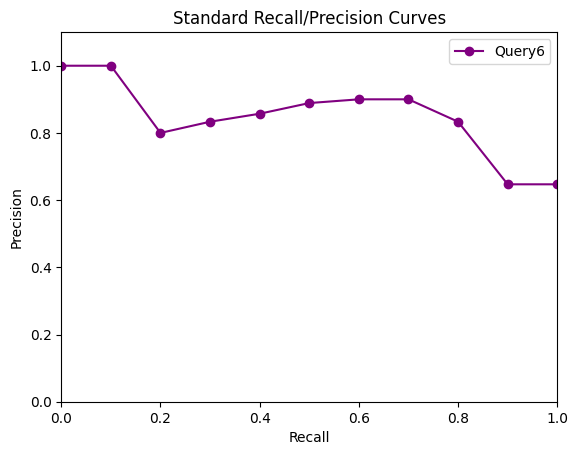

Recall@1~10:  [0.07 0.14 0.21 0.29 0.29 0.36 0.36 0.43 0.5  0.57]
Precision@1~10:  [1.   1.   1.   1.   0.8  0.83 0.71 0.75 0.78 0.8 ]
F1measure@1~10:  [0.13 0.25 0.35 0.44 0.42 0.5  0.48 0.55 0.61 0.67]


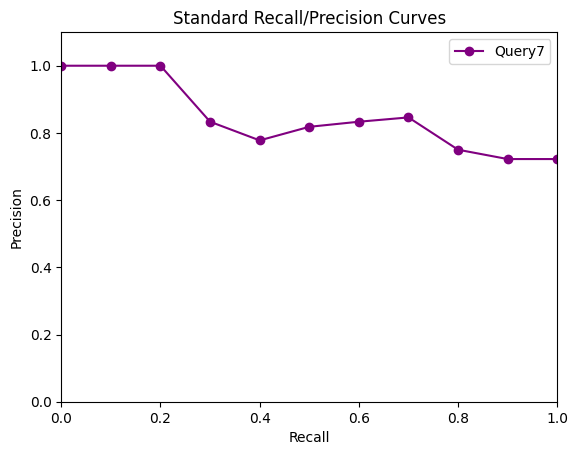

Recall@1~10:  [0.08 0.15 0.23 0.23 0.31 0.31 0.38 0.46 0.54 0.62]
Precision@1~10:  [1.   1.   1.   0.75 0.8  0.67 0.71 0.75 0.78 0.8 ]
F1measure@1~10:  [0.14 0.27 0.38 0.35 0.44 0.42 0.5  0.57 0.64 0.7 ]


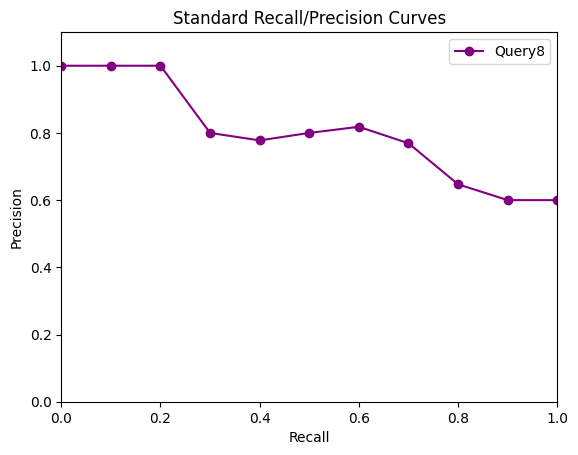


Average Recall, average Precision, average F1-measure: 
Average Recall@1~10:  [0.09 0.16 0.21 0.3  0.36 0.44 0.49 0.54 0.59 0.64]
Average Precision@1~10:  [0.88 0.81 0.75 0.75 0.75 0.75 0.73 0.73 0.72 0.71]
Average F1measure@1~10:  [0.16 0.26 0.32 0.41 0.47 0.53 0.56 0.6  0.62 0.65]


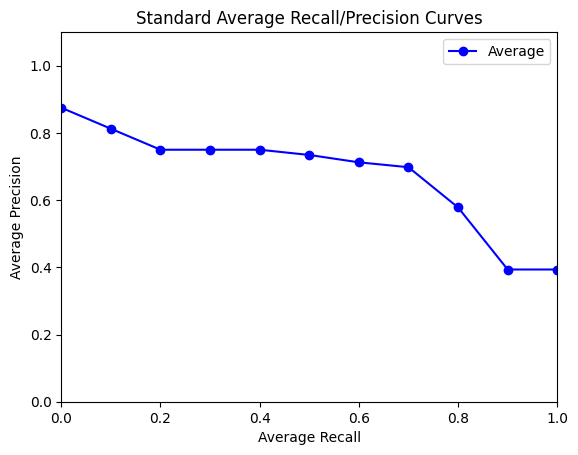

In [83]:
# This code is copied from the Lab Tutorials although in some of the part changes were made to fulfill the requirements.

import matplotlib.pyplot as plt


# Interplot Precision for standard Recall
def InterplotPrecision(p=0.1, Precision=None, Recall=None):
    if p >= 1.0:
        p = 0.9

    Mark = np.zeros(2)
    l = 0
    r = 0
    for i in range(len(Recall)):
        if Recall[i] >= p and Mark[0] == 0:
            l = i
            Mark[0] = 1
        if Recall[i] >= p + 0.1 and Mark[1] == 0:
        # if Recall[i] >= 1.0 and Mark[1] == 0:
            r = i
            Mark[1] = 1
    y = max(Precision[l:(r+1)])
    return y

# obtain y axis for R/P curve
def compute_RP_yaxis(Precision=None, Recall=None):
  y_axis = [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
  for i in range(11):
    pInput = 0.1 * i
    y_axis[i] = InterplotPrecision(p=pInput, Precision=Precision, Recall=Recall)
  return y_axis


# compute Recall, Precision, F1-measure
def compute_R_P_F1(re_mark=None, QuRe_ID =None):
  Recall = []
  Precision = []
  F1measure = []
  for i in range(len(re_mark)):
    r = sum(re_mark[:(i+1)])
    Re = r/(len(QuRe_ID))
    Pr = r/(i+1)
    # avoid divisor to be 0
    FD = Re + Pr
    if FD == 0:
      FD=1
    F1 = 2*Re*Pr/FD

    Recall.append(Re)
    Precision.append(Pr)
    F1measure.append(F1)
  return Recall, Precision, F1measure


Xtrain =  prepare_data(train_docs, col_weight, vocab)


trunc_SVD_model = TruncatedSVD(n_components=row_component)
approx_Xtrain = trunc_SVD_model.fit_transform(Xtrain)



AllRecall = []
AllPrecision = []
AllF1measure = []
y_axis_LSA = []
# loop queries
j = 0
for query in Querys:
  # retrieval
  encoded_query = preprocess_review_query(query, 'tfidf', vocab)
  transformed_query = trunc_SVD_model.transform(encoded_query)
  similarities = cosine_similarity(approx_Xtrain, transformed_query)


  # rank the index
  selected_indexes = np.argsort(similarities.flat)[::-1]

  selected_indexes = ConvertIndexesToID(selected_indexes,df)

  # Mark the relevant index
  re_mark = []

  for i in range(len(selected_indexes)):
    if (selected_indexes[i]) in query_values_list[j]:
      re_mark.append(1)
    else:
      re_mark.append(0)

  # compute Recall, Precision, F1-measure
  Recall, Precision, F1measure = compute_R_P_F1(re_mark=re_mark, QuRe_ID=query_values_list[j])



  Recall = np.array(Recall)
  Precision = np.array(Precision)
  F1measure = np.array(F1measure)
  # print(re_mark)
  print("Recall@1~10: ", np.around(Recall[:10],2))
  print("Precision@1~10: ", np.around(Precision[:10],2))
  print("F1measure@1~10: ", np.around(F1measure[:10],2))


  # plot R/P curve
  x_axis = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
  y_axis = compute_RP_yaxis(Precision=Precision, Recall=Recall)
  y_axis_LSA.append(y_axis)
  plt.plot(x_axis, y_axis, '-bo', color="purple", label="Query%d"%(j+1))
  plt.xlim(0, 1)
  plt.ylim(0, 1.1)
  plt.xlabel('Recall')
  plt.ylabel('Precision')
  plt.title('Standard Recall/Precision Curves')
  plt.legend()
  plt.show()

  AllRecall.append(Recall)
  AllPrecision.append(Precision)
  AllF1measure.append(F1measure)

  j += 1

# compute average Recall, average Precision, average F1-measure
AllRecall = np.array(AllRecall)
AllPrecision = np.array(AllPrecision)
AllF1measure = np.array(AllF1measure)

AveRecall = (AllRecall[0] + AllRecall[1] + AllRecall[2] + AllRecall[3] + AllRecall[4] + AllRecall[5] + AllRecall[6] + AllRecall[7])/8
AvePrecision = (AllPrecision[0] + AllPrecision[1] + AllPrecision[2]+ AllPrecision[3]+ AllPrecision[4]+ AllPrecision[5]+ AllPrecision[6]+ AllPrecision[7])/8
AveF1measure = (AllF1measure[0] + AllF1measure[1]+ AllF1measure[2]+ AllF1measure[3]+ AllF1measure[4]+ AllF1measure[5]+ AllF1measure[6]+ AllF1measure[7])/8


print("\nAverage Recall, average Precision, average F1-measure: ")
print("Average Recall@1~10: ", np.around(AveRecall[:10],2))
print("Average Precision@1~10: ", np.around(AvePrecision[:10],2))
print("Average F1measure@1~10: ", np.around(AveF1measure[:10],2))



# plot average R/P curve
# plot average R/P curve
x_axis = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
y_axis = compute_RP_yaxis(Precision=AvePrecision, Recall=AveRecall)

plt.plot(x_axis, y_axis, '-bo', color="blue", label="Average")
plt.xlim(0, 1)
plt.ylim(0, 1.1)

# plt.plot(AveRecall, AvePrecision,'-bo', color="blue", label="Average")
plt.xlabel('Average Recall')
plt.ylabel('Average Precision')
plt.title('Standard Average Recall/Precision Curves')
plt.legend()
plt.show()

In [84]:
# Creating the DataFrame for all the top 10 index for 8 query we find similarity for.
data = {
    'Rank': list(range(1, 11)),
    'Average Recall@1~10': np.around(AveRecall[:10], 2),
    'Average Precision@1~10': np.around(AvePrecision[:10], 2),
    'Average F1-measure@1~10': np.around(AveF1measure[:10], 2)
}

query_df = pd.DataFrame(data)

# Setting the 'Rank' column as index
query_df.set_index('Rank', inplace=True)

# Displaying the DataFrame
query_df

,Average Recall@1~10,Average Precision@1~10,Average F1-measure@1~10
Rank,,,
1,0.09,0.88,0.16
2,0.16,0.81,0.26
3,0.21,0.75,0.32
4,0.30,0.75,0.41
5,0.36,0.75,0.47
6,0.44,0.75,0.53
7,0.49,0.73,0.56
8,0.54,0.73,0.60
9,0.59,0.72,0.62


**Brief Observations**

Average Recall@1~10: This starts at a low value of 0.07 at rank 1 and increases gradually to 0.65 at rank 10. This means that as you look at more items in the list, you tend to find more relevant ones, with the proportion of relevant items increasing as you move down the list.

Average Precision@1~10: This starts high at rank 1 (0.75) and decreases gradually to 0.71 at rank 10. It indicates that although you retrieve more relevant items as you go further down the list, the accuracy of these items decreases, making the relevance of what you find less reliable.

Average F1-measure@1~10: This metric starts moderately low at rank 1 (0.12) and increases gradually to 0.65 at rank 10. It shows a balance between finding relevant items and finding them accurately.

Overall, these metrics highlight the trade-offs between recall, precision, and their F1-measure across different ranks.

# Task 3
## Neural information retrieval


### 3(a) Develop a neural information retrieval model (5 marks).

In [85]:
# Process the given queries and store them in 'processed_queries'
processed_queries = process_docs(Querys)

In [86]:
!pip install --quiet sentence_transformers

In [87]:
# Import the SentenceTransformer library and use a pretrained model named 'all-mpnet-base-v2'
from sentence_transformers import SentenceTransformer

# I chose the 'all-mpnet-base-v2' pre-trained model because it performed better than other models like BERT, which didn't give good results in my evaluations.
embedding_model = SentenceTransformer('all-mpnet-base-v2')

In [88]:
# Encode the preprocessed reviews using the loaded model and store the embeddings in 'query_embeddings'
reviews_embeddings = embedding_model.encode(train_docs)

In [89]:
reviews_embeddings.shape  # Look at the shape

(201, 768)

In [90]:
# This code is adapted from the Lab Tutorials, changes were made to fulfill the requirements.

# Initialize an empty list to store the top indexes for each query
all_top_indexes = []

# Loop through each query in the list
for query in Querys:
    # Retrieve embeddings for the current query
    embeddings_query = embedding_model.encode(query)

    # Calculate cosine similarity between the current query and all document embeddings
    similarities = cosine_similarity(reviews_embeddings, [embeddings_query])

    # Define the number of top reviews to extract
    top_n_reviews = 10

    # Sort the similarity scores in descending order to get the indexes of the top N reviews
    selected_indexes = np.argsort(similarities.flat)[::-1]
    selected_indexes = selected_indexes[:top_n_reviews]

    # Append the top indexes for the current query to the list
    all_top_indexes.append(selected_indexes)


In [91]:
# Convert the top indexes to review IDs
neural_index_review_id = convert_index_to_review_id(all_top_indexes, df)


Performance of our Neural Network

In [92]:
# Calculate the precision score for the neural network model
neural_network_best = calculate_precision(Querys, neural_index_review_id, query_values_list)

neural_network_best

50.0

### 3(b) Compare its performance to that of your best-tuned LSI model (from Task 2). Present all results in tables and graphs and explain the findings (max 100 words) (5 marks).

Recall@1~10:  [0.06 0.12 0.19 0.25 0.25 0.25 0.25 0.25 0.25 0.31]
Precision@1~10:  [1.   1.   1.   1.   0.8  0.67 0.57 0.5  0.44 0.5 ]
F1measure@1~10:  [0.12 0.22 0.32 0.4  0.38 0.36 0.35 0.33 0.32 0.38]


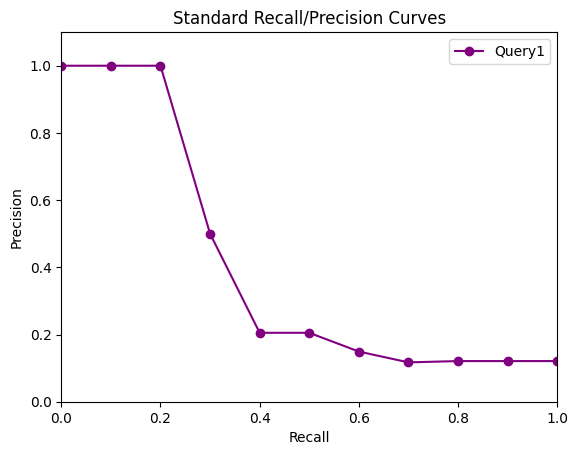

Recall@1~10:  [0.17 0.33 0.5  0.67 0.83 1.   1.   1.   1.   1.  ]
Precision@1~10:  [1.   1.   1.   1.   1.   1.   0.86 0.75 0.67 0.6 ]
F1measure@1~10:  [0.29 0.5  0.67 0.8  0.91 1.   0.92 0.86 0.8  0.75]


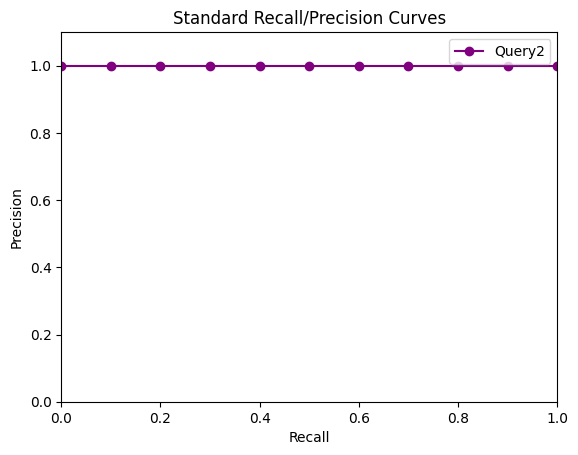

Recall@1~10:  [0.07 0.07 0.07 0.14 0.21 0.29 0.36 0.36 0.43 0.5 ]
Precision@1~10:  [1.   0.5  0.33 0.5  0.6  0.67 0.71 0.62 0.67 0.7 ]
F1measure@1~10:  [0.13 0.12 0.12 0.22 0.32 0.4  0.48 0.45 0.52 0.58]


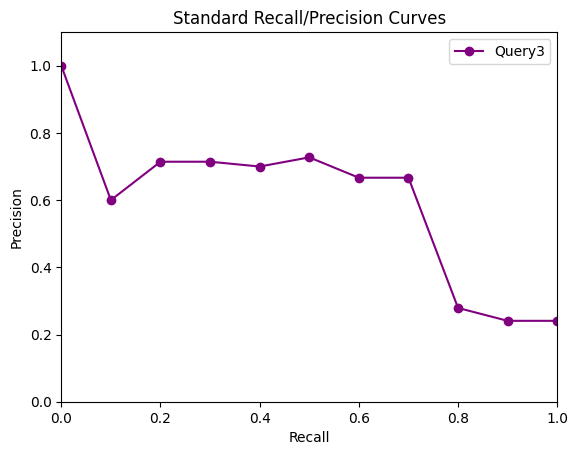

Recall@1~10:  [0.07 0.14 0.21 0.29 0.29 0.36 0.36 0.43 0.5  0.5 ]
Precision@1~10:  [1.   1.   1.   1.   0.8  0.83 0.71 0.75 0.78 0.7 ]
F1measure@1~10:  [0.13 0.25 0.35 0.44 0.42 0.5  0.48 0.55 0.61 0.58]


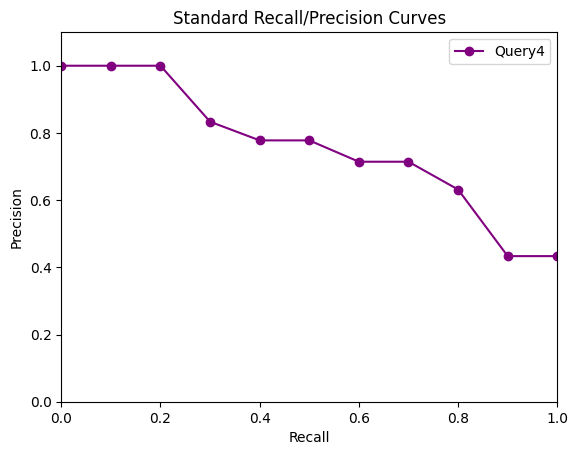

Recall@1~10:  [0.2 0.2 0.2 0.2 0.4 0.4 0.4 0.4 0.4 0.4]
Precision@1~10:  [1.   0.5  0.33 0.25 0.4  0.33 0.29 0.25 0.22 0.2 ]
F1measure@1~10:  [0.33 0.29 0.25 0.22 0.4  0.36 0.33 0.31 0.29 0.27]


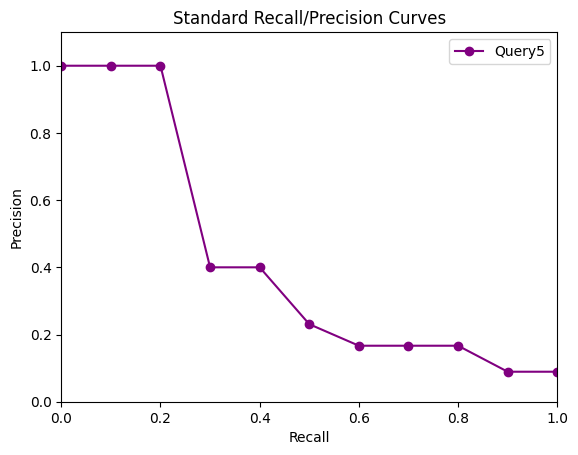

Recall@1~10:  [0.08 0.08 0.17 0.25 0.25 0.25 0.25 0.25 0.33 0.42]
Precision@1~10:  [1.   0.5  0.67 0.75 0.6  0.5  0.43 0.38 0.44 0.5 ]
F1measure@1~10:  [0.15 0.14 0.27 0.38 0.35 0.33 0.32 0.3  0.38 0.45]


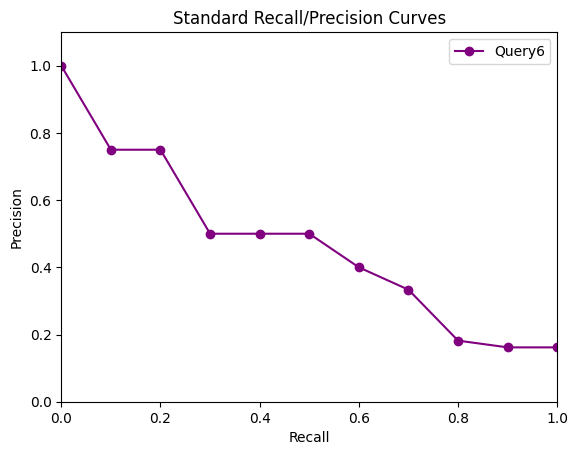

Recall@1~10:  [0.07 0.14 0.21 0.29 0.36 0.36 0.36 0.36 0.36 0.36]
Precision@1~10:  [1.   1.   1.   1.   1.   0.83 0.71 0.62 0.56 0.5 ]
F1measure@1~10:  [0.13 0.25 0.35 0.44 0.53 0.5  0.48 0.45 0.43 0.42]


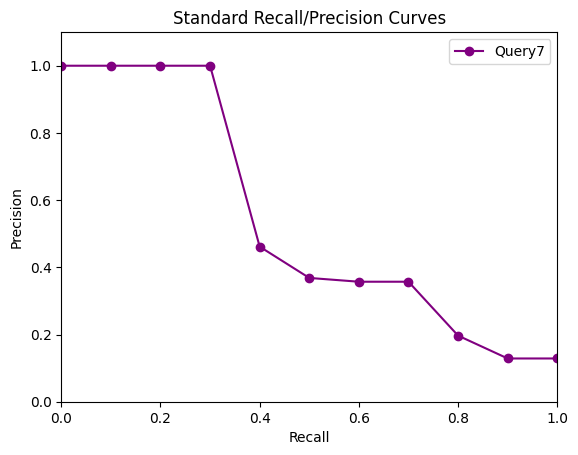

Recall@1~10:  [0.08 0.15 0.15 0.15 0.15 0.15 0.15 0.15 0.15 0.23]
Precision@1~10:  [1.   1.   0.67 0.5  0.4  0.33 0.29 0.25 0.22 0.3 ]
F1measure@1~10:  [0.14 0.27 0.25 0.24 0.22 0.21 0.2  0.19 0.18 0.26]


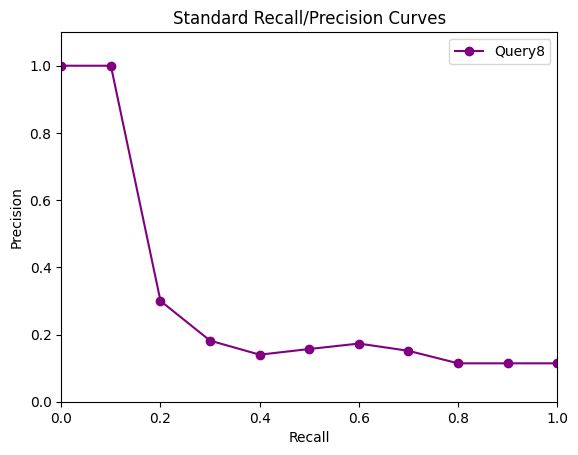


Average Recall, average Precision, average F1-measure: 
Average Recall@1~10:  [0.1  0.16 0.21 0.28 0.34 0.38 0.39 0.4  0.43 0.46]
Average Precision@1~10:  [1.   0.81 0.75 0.75 0.7  0.65 0.57 0.52 0.5  0.5 ]
Average F1measure@1~10:  [0.18 0.26 0.32 0.39 0.44 0.46 0.44 0.43 0.44 0.46]


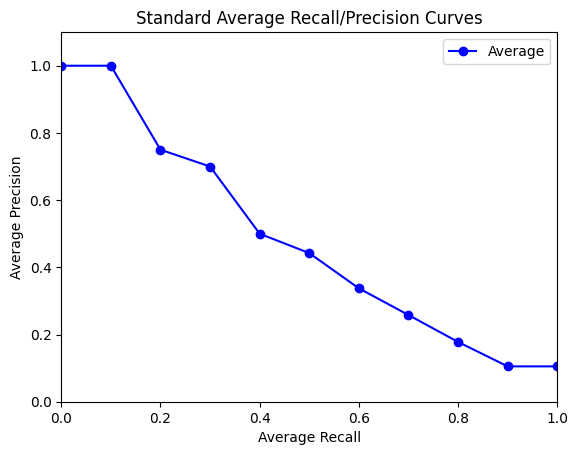

In [93]:
# This code is copied from the Lab Tutorials although in some of the part changes were made to fulfill the requirements.


AllRecall = []
AllPrecision = []
AllF1measure = []
y_axis_LSA = []
# loop queries
j = 0
for query in Querys:
  # Retrieve query embeddings
  embeddings_query = embedding_model.encode(query)

  # Calculate cosine similarity between query and all document embeddings
  similarities = cosine_similarity(reviews_embeddings, [embeddings_query])

  # rank the index
  sorted_indices = np.argsort(similarities.flat)[::-1]

  sorted_indices_id = ConvertIndexesToID(sorted_indices, df)

  # Mark the relevant index
  re_mark = []

  for i in range(len(sorted_indices_id)):
    if (sorted_indices_id[i]) in query_values_list[j]:
      re_mark.append(1)
    else:
      re_mark.append(0)

  # compute Recall, Precision, F1-measure
  Recall, Precision, F1measure = compute_R_P_F1(re_mark=re_mark, QuRe_ID=query_values_list[j])



  Recall = np.array(Recall)
  Precision = np.array(Precision)
  F1measure = np.array(F1measure)
  # print(re_mark)
  print("Recall@1~10: ", np.around(Recall[:10],2))
  print("Precision@1~10: ", np.around(Precision[:10],2))
  print("F1measure@1~10: ", np.around(F1measure[:10],2))


  # plot R/P curve
  x_axis = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
  y_axis = compute_RP_yaxis(Precision=Precision, Recall=Recall)
  y_axis_LSA.append(y_axis)
  plt.plot(x_axis, y_axis, '-bo', color="purple", label="Query%d"%(j+1))
  plt.xlim(0, 1)
  plt.ylim(0, 1.1)
  plt.xlabel('Recall')
  plt.ylabel('Precision')
  plt.title('Standard Recall/Precision Curves')
  plt.legend()
  plt.show()

  AllRecall.append(Recall)
  AllPrecision.append(Precision)
  AllF1measure.append(F1measure)

  j += 1

# compute average Recall, average Precision, average F1-measure
AllRecall = np.array(AllRecall)
AllPrecision = np.array(AllPrecision)
AllF1measure = np.array(AllF1measure)

AveRecall = (AllRecall[0] + AllRecall[1] + AllRecall[2] + AllRecall[3] + AllRecall[4] + AllRecall[5] + AllRecall[6] + AllRecall[7])/8
AvePrecision = (AllPrecision[0] + AllPrecision[1] + AllPrecision[2]+ AllPrecision[3]+ AllPrecision[4]+ AllPrecision[5]+ AllPrecision[6]+ AllPrecision[7])/8
AveF1measure = (AllF1measure[0] + AllF1measure[1]+ AllF1measure[2]+ AllF1measure[3]+ AllF1measure[4]+ AllF1measure[5]+ AllF1measure[6]+ AllF1measure[7])/8


print("\nAverage Recall, average Precision, average F1-measure: ")
print("Average Recall@1~10: ", np.around(AveRecall[:10],2))
print("Average Precision@1~10: ", np.around(AvePrecision[:10],2))
print("Average F1measure@1~10: ", np.around(AveF1measure[:10],2))



# plot average R/P curve
# plot average R/P curve
x_axis = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
y_axis = compute_RP_yaxis(Precision=AvePrecision, Recall=AveRecall)

plt.plot(x_axis, y_axis, '-bo', color="blue", label="Average")
plt.xlim(0, 1)
plt.ylim(0, 1.1)

# plt.plot(AveRecall, AvePrecision,'-bo', color="blue", label="Average")
plt.xlabel('Average Recall')
plt.ylabel('Average Precision')
plt.title('Standard Average Recall/Precision Curves')
plt.legend()
plt.show()

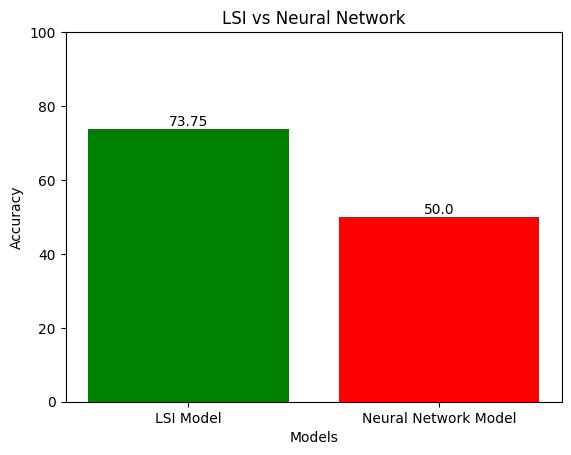

In [152]:
# The following method represents my original idea and code, since the task require this to be added.

import matplotlib.pyplot as plt

# Names of the models
models = ['LSI Model', 'Neural Network Model']

# Scores of the models
scores = [lsi_model_best, neural_network_best]

# Define colors for each bar
bar_colors = ['green', 'red']

# Plotting
plt.bar(models, scores, color=bar_colors)

# Annotate values on top of each bar
for i, score in enumerate(scores):
    plt.text(i, score + 0.01, str(score), ha='center', va='bottom')

# Adding labels and title
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.title('LSI vs Neural Network')

# Setting y-axis limit
plt.ylim(0, 100)

# Show plot
plt.show()


**Brief Observation**

The LSI model is better, achieving 73.75% accuracy compared to the Neural Network's 50%. The Neural Network's complexity may cause its lower precision, needing more data to learn well. LSI simplifies data with linear algebra, while Neural Networks are complex and prone to overfitting. When data is limited, the Neural Network struggles to generalize, making LSI more dependable for accurate predictions. This shows that simplicity, like LSI's approach, can often lead to better results in prediction tasks, especially when data is scarce

### 3(c) Develop an interactive interface that will allow the user to type in a new query and interact with the results (5 marks).

The textbox widget is interactive, so the results will update as you type your query. Initially, a default value is provided in the text box, but you can easily replace it with your own query.

**Note: This output part of the code will not be visible in the pdf as reason mentioned in the title part. Please refer the .ipynb file to the see the ouput.**

In [95]:
# The following method represents my original idea and code, since the task require this to be added.

from ipywidgets import interact, widgets, Layout, HBox, Output
import pandas as pd

# Assuming you have your dataframe df and other necessary objects defined

dataframe = pd.read_csv(filename)

selected_indexes_query = None

# Define a function for the interactive search
def interactive_search(change):
    global selected_indexes_query  # Access the global variable
    query = change['new']
    if not query:
      with output:
          output.clear_output(wait=True)
          print("Please enter a query.")

    else:
      query = doc_to_line(query)
      output.clear_output(wait=True)

      # Retrieve query embeddings
      embeddings_query = embedding_model.encode(query)

      # Calculate cosine similarity between query and all document embeddings
      similarities = cosine_similarity(reviews_embeddings, [embeddings_query])

      # Extract top N reviews based on similarity scores
      top_n_reviews = 10
      selected_indexes_query = np.argsort(similarities.flat)[::-1]
      selected_indexes = selected_indexes_query[:top_n_reviews]
      selected_indexes = ConvertIndexesToID(selected_indexes, df)

      # Initialize an empty list to store DataFrames
      selected_rows_list = []

      # Use a for loop to extract rows based on selected IDs
      for selected_id in selected_indexes:
          selected_row = dataframe[dataframe['ID'] == selected_id]
          selected_rows_list.append(selected_row)

      # Concatenate the list of DataFrames into a single DataFrame
      selected_rows = pd.concat(selected_rows_list, ignore_index=True)

      # Sort the new DataFrame by 'ID' column
      selected_rows = selected_rows.reset_index(drop=True)

      # selected_rows = dataframe[dataframe['ID'].isin(selected_indexes)].reset_index(drop=True)
      selected_rows.index += 1

      # Set the maximum column width for text content
      pd.set_option('display.max_colwidth', 10)

      with output:
          display(HTML(selected_rows[['ID', 'Reviews', 'Ratings']].to_html()))




# Create a label widget
label_widget = widgets.Label(value='Interactive widgets:')

default_value = '''I got this ring for my birthday and I love it, I cannot imagine a woman not adoring this ring.'''
# Create an interactive widget for entering queries with 50% width
query_widget = widgets.Text(value=default_value, description='Query:', layout=Layout(width='70%'))

# Create an Output widget to display the results
output = Output(layout=Layout(width='80%'))

# Call the interactive_search function with default query to invoke it for the first time
interactive_search({'new': default_value})

# Register the function to be called when the user changes the query
query_widget.observe(interactive_search, names='value')

# Arrange the widgets vertically using VBox
widgets_box = HBox([label_widget,query_widget])

# Display the widgets
display(widgets_box, output)




Output(layout=Layout(width='80%'))

In [96]:
selected_indexes_query

array([ 19,  90,  88,   9, 108,  87, 106, 104,  22,  93,  67,  52,  49,
       107,  34, 105,  68,  81, 111,  24, 181, 117,  64,  51,  73,  27,
        72,  30,  53, 171,  71,  50,  66,  91,  20, 114,  59, 176,  74,
        55,  10,  56, 115,  60, 119,  11, 109, 179,  58,  86,  80,  38,
        70, 184,  69, 113,  79, 118,  65,  75, 120, 175,  89,  48,  46,
         3,   4,  16,  17,  23, 165,  40,  35,  77,   2,  26,   1,  33,
        25, 147, 178,  54, 182, 121, 124,  37,  99, 125, 183,  28,  13,
       172, 173,  76, 180,  84,  83,  85,  61, 149,  57, 112, 150,  63,
        82,  44, 122, 123,  92,  21,  18,  41, 196, 148, 177, 170,  62,
       156, 110, 144, 174, 139,  32,  31, 133, 130,  95,  94, 163, 140,
        42,  47,  39, 135, 191, 162, 161, 160, 166, 142,  43, 101, 199,
       198, 200,  97,  96, 102, 152, 145,  45,  78,  98, 154, 126, 100,
       128, 167, 137, 190,  12, 134, 138, 146,   5, 141, 153,  36, 187,
        15, 159, 132, 157, 193, 185, 192, 158, 103, 155, 127,   

# TASK 4
## Clustering and analysis

### 4(a) Extend your answer to Task 3 to include clustering of search results. This algorithm should take as input the top n search results of a chosen query and cluster them into topics (n can be user-defined and for experimental purposes set n to 50). Note: perform clustering on sentence embeddings to group  sentences by semantic similarity. (5 marks)







In [97]:
!pip install --upgrade gensim
!pip install --upgrade spacy
!pip install --upgrade nltk
!pip install --upgrade pyLDAvis
!pip install spacytextblob
!python -m textblob.download_corpora
!python -m spacy download en_core_web_sm

[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Package brown is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package conll2000 to /root/nltk_data...
[nltk_data]   Package conll2000 is already up-to-date!
[nltk_data] Downloading package movie_reviews to /root/nltk_data...
[nltk_data]   Package movie_reviews is already up-to-date!
Finished.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 25.9 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If y

**Note:**

For this particular task the idea is taken from https://www.linkedin.com/pulse/nlp-a-complete-guide-topic-modeling-latent-dirichlet-sahil-m/

This code is adapted from the link but many changes were made to fulfill the given requirement.

In [98]:
# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from nltk.corpus import stopwords
import spacy
import warnings
warnings.filterwarnings("ignore")
from pprint import pprint

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

In [99]:
import pandas as pd

# Retrieve the top N reviews based on similarity scores
top_n_reviews = 50

# Get the top N indexes from the similarity scores
selected_indexes = selected_indexes_query[:top_n_reviews]

# Convert the indexes to review IDs
selected_indexes = ConvertIndexesToID(selected_indexes, df)

# Initialize an empty list to store DataFrames
selected_rows_list = []

# Extract rows based on the selected IDs
for selected_id in selected_indexes:
    selected_row = dataframe[dataframe['ID'] == selected_id]
    selected_rows_list.append(selected_row)

# Concatenate the list of DataFrames into a single DataFrame
query_result_df = pd.concat(selected_rows_list, ignore_index=True)

# Reset the index of the new DataFrame
query_result_df = query_result_df.reset_index(drop=True)

# Extract the 'Reviews' column from the DataFrame
reviews = query_result_df['Reviews'].tolist()

# Process the reviews
processed_reviews = process_docs(reviews)

# Print the processed reviews
print(processed_reviews)


['got thi ring birthday love cannot imagin woman ador thi ring', 'got thi ring birthday love cannot imagin woman ador thi ring', 'want know thi ring like ring one becaus thi ring beyond gorgeous love', 'want know thi ring like ring one becaus thi ring beyond gorgeous love', 'got thi ring gift boyfriend love onli thing ring posit correctli pinch skin', 'fianc look mani differ ring fell love thi ring wa everyth want engag ring wear awhil perfect regret buy thi ring', 'thi wa birthday gift yo niece love ring wa veri happi receiv', 'got ring promis ring girlfriend christma love definit great value', 'onli ring beautiful jewel wa veri accommad ring reach time appreci care quick receiv ring thank', 'onli ring beautiful jewel wa veri accommad ring reach time appreci care quick receiv ring thank', 'love ring suggest everi girl thi ring jewelri collection', 'absolut love thi ring got thi engag ring feb thi ring beauti durable', 'thi ring perfect say whi spend thousand dont ring shine perfectli 

In [100]:
# Tokenize each sentence into a list of words while removing punctuation and unnecessary characters.
# Gensim’s simple_preprocess() function is utilized for this purpose, with deacc=True to eliminate punctuation.

stop_words = stopwords.words('english')
stop_words.extend(['from', 'to', 'look' ,'the','wa', 'would', 'thi', 'alway'])

# Spacy lemmatization
nlp = spacy.load("en_core_web_sm")


# Tokenize sentences into lists of words, removing punctuation and unnecessary characters.
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc))
             if word not in stop_words] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN']):
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent))
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

# Convert the processed reviews to lists of words.
reviews_list = list(sent_to_words(processed_reviews))

# Remove stopwords from the reviews.
reviews_list = remove_stopwords(reviews_list)

# Lemmatize the reviews keeping only nouns.
reviews_list = lemmatization(reviews_list, allowed_postags=['NOUN'])

print(reviews_list)

[['ring', 'birthday', 'love', 'ring'], ['ring', 'birthday', 'love', 'ring'], ['ring', 'becaus', 'ring', 'love'], ['ring', 'becaus', 'ring', 'love'], ['ring', 'gift', 'boyfriend', 'love', 'onli', 'thing', 'ring', 'skin'], ['fianc', 'ring', 'love', 'ring', 'engag', 'ring'], ['birthday', 'gift', 'ring'], ['girlfriend', 'definit', 'value'], ['ring', 'ring', 'time', 'ring'], ['ring', 'ring', 'time', 'ring'], ['love', 'ring', 'girl', 'ring', 'collection'], ['ring'], ['ring', 'whi', 'ring', 'love', 'ring'], ['topaz', 'ring', 'gift', 'birthday', 'year', 'definit', 'gift', 'addit', 'collection'], ['ring', 'ship', 'accordingli', 'love', 'ship', 'pace', 'ring', 'onli', 'thing', 'line', 'ring'], ['love', 'gift', 'quality'], ['ring', 'ring', 'dollar', 'ring', 'course', 'head', 'ring', 'ring', 'authent', 'scrutini', 'diamond', 'ring', 'ring', 'ring', 'price', 'choic', 'want', 'turn', 'head', 'bank'], ['engag', 'ring', 'birthday', 'lol', 'ring', 'anyon'], ['ring'], ['valentine', 'gift', 'hand', 'hear

In [101]:
# Create a dictionary mapping token IDs to words.
id2word = corpora.Dictionary(reviews_list)
print(id2word)

# Create a corpus, which is a list of bags of words representation of each document.
texts = reviews_list

# Convert the texts into a bag of words format using the dictionary.
corpus = [id2word.doc2bow(text) for text in texts]

# View the term document frequency of the first document in the corpus.
print(corpus[:1])


Dictionary<157 unique tokens: ['birthday', 'love', 'ring', 'becaus', 'boyfriend']...>
[[(0, 1), (1, 1), (2, 2)]]


In [102]:
# Convert the corpus into a human-readable format representing term-frequency pairs.
# Each sublist corresponds to a document in the corpus, where each element is a tuple containing the word (from the dictionary) and its frequency.
human_readable_corpus = [[(id2word[id], freq) for id, freq in document] for document in corpus[:5]]
print(human_readable_corpus)


[[('birthday', 1), ('love', 1), ('ring', 2)], [('birthday', 1), ('love', 1), ('ring', 2)], [('love', 1), ('ring', 2), ('becaus', 1)], [('love', 1), ('ring', 2), ('becaus', 1)], [('love', 1), ('ring', 2), ('boyfriend', 1), ('gift', 1), ('onli', 1), ('skin', 1), ('thing', 1)]]


In [103]:
# Implement a baseline LDA (Latent Dirichlet Allocation) model using Gensim.
# This model is trained on the provided corpus with the specified parameters.
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=5,
                                           random_state=100,
                                           chunksize=200,
                                           passes=10,
                                           per_word_topics=True)


In [104]:
# Print the top keywords for each of the 5 topics identified by the LDA model.
pprint(lda_model.print_topics())

# Generate topic distributions for all documents in the corpus.
doc_lda = lda_model[corpus]


[(0,
  '0.327*"ring" + 0.030*"love" + 0.021*"diamond" + 0.018*"stone" + '
  '0.018*"engag" + 0.018*"band" + 0.018*"time" + 0.013*"price" + 0.013*"size" '
  '+ 0.013*"fit"'),
 (1,
  '0.259*"ring" + 0.069*"love" + 0.042*"gift" + 0.023*"birthday" + '
  '0.019*"definit" + 0.019*"stone" + 0.015*"price" + 0.010*"time" + '
  '0.010*"girlfriend" + 0.010*"tongu"'),
 (2,
  '0.035*"noth" + 0.031*"picture" + 0.021*"diamond" + 0.006*"ring" + '
  '0.006*"love" + 0.006*"birthday" + 0.006*"girlfriend" + 0.006*"quality" + '
  '0.006*"value" + 0.006*"gift"'),
 (3,
  '0.151*"ring" + 0.030*"love" + 0.030*"stone" + 0.030*"ship" + 0.016*"thing" '
  '+ 0.016*"onli" + 0.016*"cost" + 0.016*"birthday" + 0.016*"return" + '
  '0.016*"accordingli"'),
 (4,
  '0.069*"ring" + 0.025*"thing" + 0.025*"onli" + 0.025*"return" + 0.025*"way" '
  '+ 0.025*"pictur" + 0.025*"end" + 0.025*"bit" + 0.025*"hope" + '
  '0.025*"signific"')]


In [105]:
# Compute the coherence score for the LDA model using the C_V coherence measure.
coherence_model_lda = CoherenceModel(model=lda_model, texts=reviews_list, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()

# Print the coherence score.
print('Coherence Score: ', coherence_lda)


Coherence Score:  0.5183534467412472


### 4(b,c) Dynamically determine the optimal number of clusters using a suitable method (5 marks).Evaluate the performance of the model using suitable evaluation metrics. Write code that interprets the scores. (5marks).



**Methodology:**

To determine the best number of topics, we use a metric called coherence value. This measures how clear and understandable the topics created by our model are. By calculating this value and plotting it, we can identify where it's highest. A higher coherence value means the topics are more meaningful and easier to grasp. As a performance metric, coherence value indicates how well our model is generating coherent topics. If the coherence value is high, it means the model is doing a good job in creating clear and meaningful topics.







In [106]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=1, step=1):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        # Build LDA model
        model = gensim.models.ldamodel.LdaModel(corpus=corpus, num_topics=num_topics, random_state=100,
                                                chunksize=200, passes=10, per_word_topics=True, id2word=dictionary)
        model_list.append(model)
        # Compute coherence score
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values



In [193]:
# The following method represents my original idea and code, since the task require this to be added.

model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus,
                                                        texts=reviews_list, start=2, limit=12, step=1)

# Create a DataFrame to store the coherence scores for different numbers of topics
df_scores = pd.DataFrame({
    'Topic Number': range(2, 12),  # The range of topic numbers
    'Coherence_Value': coherence_values  # The coherence scores corresponding to each topic number
})

# Reset the index of the DataFrame and shift it by 1
df_scores = df_scores.reset_index(drop=True)
df_scores.index += 1  # Shift the index by 1 for better readability
df_scores


,Topic Number,Coherence_Value
1,2,0.51
2,3,0.49
3,4,0.45
4,5,0.52
5,6,0.51
6,7,0.49
7,8,0.46
8,9,0.43
9,10,0.47
10,11,0.49


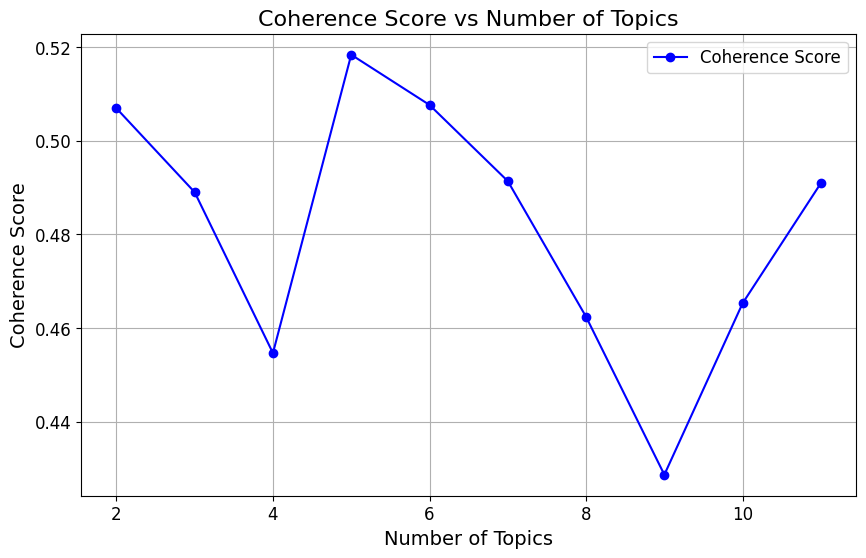

In [196]:
# The following method represents my original idea and code, since the task require this to be added.

import matplotlib.pyplot as plt

# Assuming coherence_values and x are defined
x = range(2, 12, 1)
# Plot coherence values against the number of topics
plt.figure(figsize=(10, 6))
plt.plot(x, coherence_values, marker='o', linestyle='-', color='b')

# Add labels and title
plt.xlabel('Number of Topics', fontsize=14)
plt.ylabel('Coherence Score', fontsize=14)
plt.title('Coherence Score vs Number of Topics', fontsize=16)

# Add grid
plt.grid(True)

# Add legend
plt.legend(['Coherence Score'], loc='best', fontsize=12)

# Set tick parameters
plt.tick_params(axis='both', which='major', labelsize=12)
plt.tick_params(axis='both', which='minor', labelsize=10)

# Show plot
plt.show()


**Observation:**

The findings show that the coherence values vary for different numbers of topics. A coherence value of 0.52 is observed for five topics, indicating well-defined topics.

In [109]:
# Find the row with the highest coherence value
max_row = df_scores.loc[df_scores['Coherence_Value'].idxmax()]

# Extract the optimal number of topics and its coherence value
optimal_topic = int(max_row['Topic Number'])
coherence_val = max_row['Coherence_Value']

# Print the results
print(f"Number of topics with highest coherence value: {optimal_topic}")
print(f"Coherence value: {round(coherence_val, 2)}")


Number of topics with highest coherence value: 5
Coherence value: 0.52


### 4(d) Develop an interactive interface that will allow the user to type in a new query and view the clustered sentences. (5 marks).

In [110]:
# Train the final LDA model with optimal number of topics
# passes: Number of passes through the entire corpus
# chunksize: Number of documents to load into memory at a time and process E step of EM

lda_model_final = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                                  id2word=id2word,
                                                  num_topics=optimal_topic,
                                                  random_state=100,
                                                  chunksize=200,
                                                  passes=10,
                                                  alpha=0.01,
                                                  eta='symmetric',
                                                  per_word_topics=True)


In [111]:
# Print the keywords in the final LDA model's topics
pprint(lda_model_final.print_topics())

# Get the topic distribution for each document in the corpus
doc_lda = lda_model_final[corpus]


[(0,
  '0.343*"ring" + 0.028*"love" + 0.022*"price" + 0.019*"diamond" + '
  '0.017*"stone" + 0.017*"want" + 0.017*"engag" + 0.017*"flower" + '
  '0.017*"band" + 0.017*"time"'),
 (1,
  '0.246*"ring" + 0.076*"love" + 0.046*"gift" + 0.026*"birthday" + '
  '0.021*"definit" + 0.021*"stone" + 0.011*"time" + 0.011*"year" + '
  '0.011*"collection" + 0.011*"girlfriend"'),
 (2,
  '0.035*"noth" + 0.032*"picture" + 0.026*"diamond" + 0.006*"ring" + '
  '0.006*"low" + 0.006*"lot" + 0.006*"gold" + 0.006*"suppriz" + 0.006*"afford" '
  '+ 0.006*"attent"'),
 (3,
  '0.151*"ring" + 0.025*"love" + 0.025*"cross" + 0.025*"thing" + 0.025*"ship" '
  '+ 0.025*"way" + 0.025*"stone" + 0.025*"onli" + 0.014*"accordingli" + '
  '0.014*"pace"'),
 (4,
  '0.053*"ring" + 0.028*"signific" + 0.028*"bit" + 0.028*"end" + 0.028*"man" + '
  '0.028*"pictur" + 0.028*"return" + 0.028*"hope" + 0.028*"recommend" + '
  '0.028*"friend"')]


**Note: This output part of the code will not be visible in the pdf as reason mentioned in the title part. Please refer the .ipynb file to the see the ouput.**

In [154]:
# This code part produce ambiquity on running and run when the whole file if run and then run it individually.
# pyLDAvis.enable_notebook()
# LDAvis_prepared = pyLDAvis.gensim.prepare(lda_model_final, corpus, id2word)
# LDAvis_prepared

PreparedData(topic_coordinates=          x     y  topics  cluster  Freq
topic                                   
1     -0.08 -0.11       1        1 42.74
0     -0.11  0.08       2        1 39.35
3      0.01  0.03       3        1 14.25
4      0.08  0.01       4        1  2.91
2      0.10 -0.00       5        1  0.75, topic_info=       Term   Freq  Total Category  logprob  loglift
86  picture   3.00   3.00  Default    30.00    30.00
30  diamond   3.00   3.00  Default    29.00    29.00
5      gift   8.00   8.00  Default    28.00    28.00
2      ring 103.00 103.00  Default    27.00    27.00
53   return   2.00   2.00  Default    26.00    26.00
..      ...    ...    ...      ...      ...      ...
19    topaz   0.02   1.37   Topic5    -5.14     0.52
20     year   0.02   2.21   Topic5    -5.14     0.05
24     ship   0.02   1.82   Topic5    -5.14     0.24
25  quality   0.02   1.37   Topic5    -5.14     0.52
26  authent   0.02   1.36   Topic5    -5.14     0.53

[250 rows x 6 columns], token_table=      Topic  Freq       Term
term                        
21        3  0.85  accord...
18        1  0.73      addit
37        2  0.71      anyon
37        3  0.35      anyon
88        1  0.90      anyth
...     ...   ...        ...
98        1  0.90     wonder
108       2  0.71       work
108       3  0.35       work
99        1  0.73      worri
20        1  0.90       year

[137 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 1, 4, 5, 3])

In [113]:
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

def format_topics_sentences(ldamodel=None, corpus=None, texts=None):
    # Initialize lists to store data
    topics = []
    topic_keywords = []
    original_texts = []

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords_str = ", ".join([word for word, prop in wp])
                topics.append(topic_keywords_str.split(',')[topic_num])
                topic_keywords.append(topic_keywords_str)
                original_texts.append(texts[i])
                break

    # Create DataFrame from the lists
    sent_topics_df = pd.DataFrame({
        'Reviews': original_texts,
        'Dominant_Topic': topics,
        'Topic_Keywords': topic_keywords
    })

    return sent_topics_df

# Call the function with your data
df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model_final, corpus=corpus, texts=reviews)


In [114]:
df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model_final, corpus=corpus, texts=reviews)
display(HTML(df_topic_sents_keywords.to_html()))

,Reviews,Dominant_Topic,Topic_Keywords
0,"I got this ring for my birthday and I love it, I cannot imagine a woman not adoring this ring.",love,"ring, love, gift, birthday, definit, stone, time, year, collection, girlfriend"
1,"I got this ring for my birthday and I love it, I cannot imagine a woman not adoring this ring.",love,"ring, love, gift, birthday, definit, stone, time, year, collection, girlfriend"
2,"I wanted to know if this ring is like 2 rings in one, because this ring is beyond gorgeous, I just love it.",love,"ring, love, gift, birthday, definit, stone, time, year, collection, girlfriend"
3,"I wanted to know if this ring is like 2 rings in one, because this ring is beyond gorgeous, I just love it.",love,"ring, love, gift, birthday, definit, stone, time, year, collection, girlfriend"
4,i got this ring as a gift from my boyfriend and i love it. the only thing is that if the rings are not position correctly it pinches the skin.,love,"ring, love, gift, birthday, definit, stone, time, year, collection, girlfriend"
5,"My fiance and I looked at many different rings and I fell in love with this ring, it was everything I wanted in an engagement ring! Now I have been wearing it for awhile now and it is perfect! No regrets buying this ring at all!",ring,"ring, love, price, diamond, stone, want, engag, flower, band, time"
6,This was a birthday gift for my 16 YO niece. She loves the ring and was very happy to have received it.,love,"ring, love, gift, birthday, definit, stone, time, year, collection, girlfriend"
7,I got the ring as a promise ring for my girlfriend for Christmas and she loved it. Definitely a great value.,love,"ring, love, gift, birthday, definit, stone, time, year, collection, girlfriend"
8,"Not only is the ring beautiful, the jeweler was very accommadating in having the ring reach us in time. We appreciate the care and quick receiving of the ring. Thank you!",ring,"ring, love, price, diamond, stone, want, engag, flower, band, time"
9,"Not only is the ring beautiful, the jeweler was very accommadating in having the ring reach us in time. We appreciate the care and quick receiving of the ring. Thank you!",ring,"ring, love, price, diamond, stone, want, engag, flower, band, time"


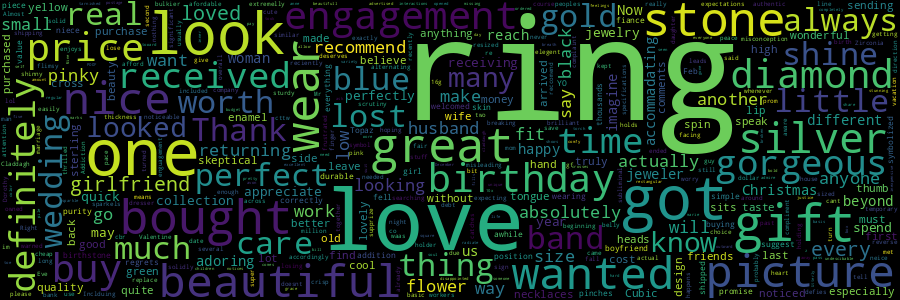

In [115]:
from wordcloud import WordCloud
# Join the different processed titles together.
combined_strings = ','.join(list(reviews))
# Create a WordCloud object
cloud = WordCloud(background_color="Black", max_words=1000, width=900,height=300,contour_width=20, contour_color='red')
# Generate a word cloud
cloud.generate(combined_strings)
# Visualize the word cloud
cloud.to_image()

In [116]:
df = pd.read_csv(filename)

In [117]:
# The following method represents my original idea and code, since the task require this to be added.

# Global variable to store selected indexes
selected_indexes = None

def process_user_query(query):
    """
    Process a user query to retrieve relevant reviews and perform topic modeling.

    Parameters:
    ----------
    query : str
        The user query.

    Returns:
    -------
    lda_model : The trained LDA model.
    corpus    : The term-document frequency matrix.
    reviews   : Processed reviews.
    """
    global selected_indexes

    # Tokenize the query
    query = doc_to_line(query)

    # Retrieve query embeddings
    embeddings_query = embedding_model.encode(query)

    # Calculate cosine similarity between query and all document embeddings
    similarities = cosine_similarity(reviews_embeddings, [embeddings_query])

    # Extract top N reviews based on similarity scores
    top_n_reviews = 50
    selected_indexes_query = np.argsort(similarities.flat)[::-1]
    selected_indexes = selected_indexes_query[:top_n_reviews]

    # Convert indexes to review IDs
    selected_indexes = ConvertIndexesToID(selected_indexes, df)

    # Initialize an empty list to store DataFrames
    selected_rows_list = []

    # Use a for loop to extract rows based on selected IDs
    for selected_id in selected_indexes:
        selected_row = dataframe[dataframe['ID'] == selected_id]
        selected_rows_list.append(selected_row)

    # Concatenate the list of DataFrames into a single DataFrame
    query_result_df = pd.concat(selected_rows_list, ignore_index=True)

    # Sort the new DataFrame by 'ID' column
    query_result_df = query_result_df.reset_index(drop=True)

    reviews = query_result_df.Reviews.values.tolist()

    processed_reviews = process_docs(reviews)

    reviews_list = list(sent_to_words(processed_reviews))
    # remove stop words
    reviews_list = remove_stopwords(reviews_list)

    # Do lemmatization keeping only noun
    reviews_list = lemmatization(reviews_list, allowed_postags=['NOUN'])

    id2word = corpora.Dictionary(reviews_list)

    # Create Corpus
    texts = reviews_list

    # Term Document Frequency
    corpus = [id2word.doc2bow(text) for text in texts]

    lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=6,
                                           random_state=100,
                                           chunksize=200,
                                           passes=10,
                                           per_word_topics=True)
    return lda_model,corpus,reviews


**Note: This output part of the code will not be visible in the pdf as reason mentioned in the title part. Please refer the .ipynb file to the see the ouput.**

Feel free to enter a new query and submit it to view the result. A default value has been provided to start with.

In [118]:
# The following method represents my original idea and code, since the task require this to be added.

import ipywidgets as widgets
from IPython.display import display
import pandas as pd


lda_model_user = None
df_topic_sents_keywords = None
# Function to process the query and display clustered sentences
def process_query(query):

    global lda_model_user

    lda_model_user,corpus,reviews = process_user_query(query)

    # Call the function with your data
    global df_topic_sents_keywords
    df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model_user, corpus=corpus, texts=reviews)

    df_topic_sents_keywords = df_topic_sents_keywords.reset_index(drop=True)

    df_topic_sents_keywords.index += 1

    with output_box:
      display(HTML(df_topic_sents_keywords.to_html()))


default_value = '''Nice ring for the an inexpensive ring, but one stone was missing. It was not worth returning it as you would pay more for postage than what the ring cost.'''

# Text input widget for the user to enter the query
query_text = widgets.Text(description="Enter Query:", value=default_value, layout=widgets.Layout(width='50%'))

# Button widget to trigger processing of the query
query_button = widgets.Button(description="Search")

# Output widget to display clustered sentences
output_box = widgets.Output(layout=Layout(width='80%'))

# Define callback function for the button click event
def on_button_click(b):
    output_box.clear_output(wait=True)
    query = query_text.value.strip()  # Get the query entered by the user
    process_query(query)  # Process the query

# Link button click event to the callback function
query_button.on_click(on_button_click)

# Call process_query with default value to invoke it for the first time
process_query(default_value)

# Arrange query box, submit button, and output box horizontally using HBox layout
query_box = widgets.HBox([query_text, query_button])
display(widgets.VBox([query_box, output_box]))



In [119]:
print(selected_indexes)

[30773, 25080, 44358, 33632, 14499, 209, 11856, 33620, 11247, 2114, 30926, 50650, 20090, 6649, 56679, 2520, 47345, 56494, 46347, 35526, 43515, 32496, 34529, 6135, 50609, 216, 19647, 33009, 54953, 41459, 48779, 28542, 7110, 34483, 49720, 45278, 58481, 27858, 55505, 18988, 55511, 51356, 39496, 57009, 11135, 36727, 39606, 53693, 6522, 21185]


### 4(e) Produce graphs that show statistics about the number of sentences per cluster and the top keywords per cluster. (5 marks).

In [120]:
# Calculate the distribution of dominant topics in the DataFrame and store the results in 'df_topic_distribution'.
df_topic_distribution = df_topic_sents_keywords['Dominant_Topic'].value_counts().reset_index(name="Num Documents")

# Rename the columns for clarity.
df_topic_distribution.columns = ['Dominant_Topic', 'Num Documents']

# Sort the DataFrame by the number of documents per dominant topic in descending order.
df_topic_distribution_sorted = df_topic_distribution.sort_values(by='Num Documents', ascending=False)

# Display the sorted distribution of dominant topics.
df_topic_distribution_sorted


,Dominant_Topic,Num Documents
0,time,22
1,ring,9
2,diamond,6
3,pictur,5
4,topaz,5
5,flaw,3


**Observation:**

Stemming algorithms may produce unexpected results in cases where the word "picture" is stemmed to "pictur". However, it's essential to remember that machine learning models, including topic modeling algorithms, interpret data differently from humans. So, even if the word appears differently, the model may still extract meaningful insights from it based on its learned associations within the dataset.

**Note: This output part of the code will not be visible in the pdf as reason mentioned in the title part. Please refer the .ipynb file to the see the ouput.**

In [189]:
# The following method represents my original idea, chatGPT was used for the styling part.

import plotly.graph_objects as go

# Extract 'Dominant_Topic' and 'Num Documents' from the DataFrame
topics = df_topic_distribution['Dominant_Topic']
num_documents = df_topic_distribution['Num Documents']


# Create a bar plot
fig = go.Figure(data=[go.Bar(
    x=topics,
    y=num_documents,
    text=num_documents,  # Display count on top of each bar
    textposition='auto',  # Automatically position the text
    marker_color='rgb(55, 83, 109)'  # Define custom color
)])

# Update layout for better appearance
fig.update_layout(
    title='Topic Distribution',
    xaxis=dict(title='Dominant Topic'),
    yaxis=dict(title='Number of Documents', range=[0, max(num_documents) * 1.3]),  # Adjust the range of the y-axis
    plot_bgcolor='white'  # Set plot background color
)

# Show plot
fig.show()





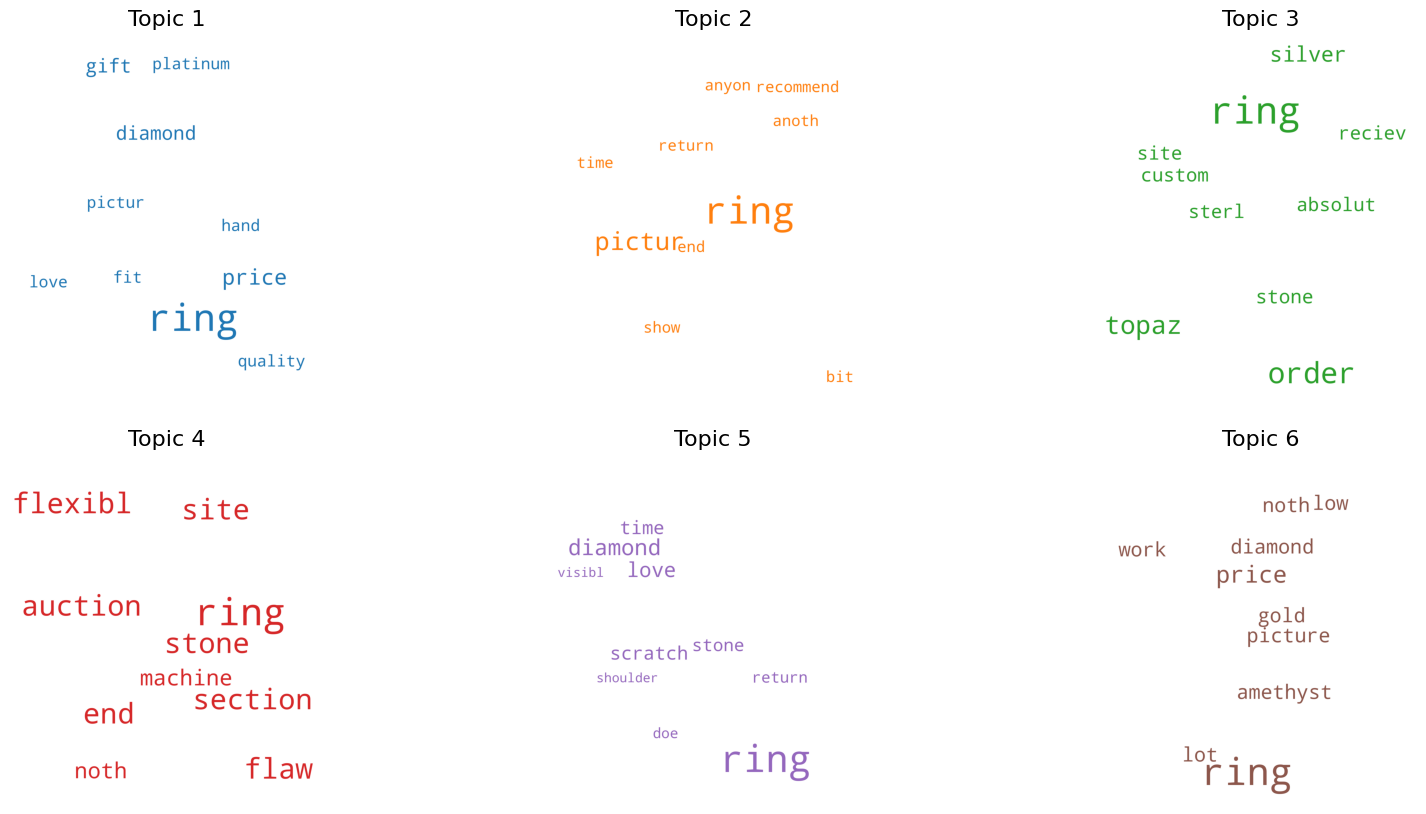

In [122]:
import matplotlib.colors as mcolors

# Extract a list of colors from the available TABLEAU_COLORS.
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # Additional colors: 'mcolors.XKCD_COLORS'

# Retrieve the topics from the trained LDA model.
topics = lda_model_user.show_topics(formatted=False)

# Create a figure and subplots for displaying word clouds.
fig, axes = plt.subplots(2, 3, figsize=(20,10), sharex=True, sharey=True)

# Initialize a WordCloud object with custom settings.
cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=2800,
                  max_words=15,
                  colormap='tab10',  # Custom colormap
                  color_func=lambda *args, **kwargs: cols[i],  # Assign colors from the colormap
                  prefer_horizontal=1.0)

# Iterate through subplots and populate them with word clouds for each topic.
for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])  # Extract words and their corresponding probabilities for the current topic
    cloud.generate_from_frequencies(topic_words, max_font_size=300)  # Generate the word cloud
    plt.gca().imshow(cloud)  # Display the word cloud
    plt.gca().set_title('Topic ' + str(i+1), fontdict=dict(size=16))  # Set title for the subplot
    plt.gca().axis('off')  # Turn off axes for better visualization



# TASK 5
## Summarise topics within clusters of search results

### 5(a,b): (a)Extend your answer to Task 4 to include an approach that takes the results from each cluster and summarises them using 2 abstractive and 2 extractive methods (10 marks).  (b) Each summary should have a meaningful title ideally comprising a short sentence (app. 5 words) (5 marks).

**Note:**

Out of curiosity, I experimented with three abstractive methods and three extractive methods to see which one performs best. After summarizing the sentences, I also generated titles for them and analyzed the most common words used across all the reviews.

In [123]:
# The following method represents my original idea and code, since the task require this to be added.

def reviews_by_topic(topic_df):
    """
    Extracts reviews for each unique topic from the provided DataFrame.

    Parameters:
    - topic_df (DataFrame): DataFrame containing topics and corresponding reviews.

    Returns:
    - reviews_dict (dict): A dictionary where each key is a unique topic and the value is a string
                           containing all reviews associated with that topic.
    """
    reviews_dict = {}
    unique_topics = topic_df['Dominant_Topic'].unique()
    for topic in unique_topics:
        reviews_list = topic_df[topic_df['Dominant_Topic'] == topic]['Reviews'].tolist()
        reviews_string = ' '.join(reviews_list)  # Concatenate all reviews into a single string
        reviews_dict[topic] = reviews_string
    return reviews_dict


# Get lists of reviews for each topic
topic_reviews = reviews_by_topic(df_topic_sents_keywords)

# Print reviews for each topic
for topic, reviews in topic_reviews.items():
    print("Reviews for topic '{}':".format(topic))
    print(reviews)
    print('---------------------------------------------')


Reviews for topic ' time':
Nice ring for the an inexpensive ring, but one stone was missing. It was not worth returning it as you would pay more for postage than what the ring cost. I usually love rings from this company but be warned that this ring doesn't look anything like the picture. The ring I received had a super long rectangular stone, not a nice square as seen in the picture. Mine was also tarnished or looked like it had torch marks up the side. I will definitely be returning this ring. This ring is exactly what I wanted, I actually bought another and it wasn't quite as solidly made as this ring is. Thanks for the great ring! I do love this ring and I wear it all the time. I bought it to wear when my husband and I go on vacation so I don't have to worry about losing my real ring. The stone is already lose but it is a $50 ring and not a $5000 ring. Almost every time I leave the house I get a compliment on this ring. My mom cannot tell the different between this ring and my real

In [124]:
# The following method represents my original idea, code debugging was done using chatGPT .

from nltk.tokenize import word_tokenize
# Function to extract keywords from a given text
def extract_title(text, num_keywords=5):
    # Tokenize the text
    tokens = word_tokenize(text)
    # Filter out stopwords
    tokens = [token.lower() for token in tokens if token.isalpha() and token.lower() not in stopwords.words('english')]
    # Count the frequency of each token
    token_counter = Counter(tokens)
    # Get the most common keywords
    keywords = [keyword for keyword, _ in token_counter.most_common(num_keywords)]
    # Use the extracted keywords as the title
    caption = ' '.join(keywords)
    title = caption.title()
    return title

In [125]:
Model_Summary = {}

**Note:**

Since the model can only handle up to 1024 words at a time, but the reviews are much longer, the code breaks down the long reviews into smaller pieces. This way, each part can be summarized separately by the model without exceeding its limit. This helps ensure that all parts of the review are properly summarized, even though they're too big for the model to process all at once.

## Abstractive Summarization Methods

##### Model 1: BRIO Model

In [126]:
# This code is adapted from the Lab Tutorials, changes were made to fulfill the requirements.

# @title
from transformers import BartTokenizer, PegasusTokenizer
from transformers import BartForConditionalGeneration, PegasusForConditionalGeneration



# Load the model checkpoints

model = BartForConditionalGeneration.from_pretrained('Yale-LILY/brio-cnndm-uncased')
tokenizer = BartTokenizer.from_pretrained('Yale-LILY/brio-cnndm-uncased')

max_length = 1024

# Function to generate summaries for each chunk of text
def generate_summaries(text_chunks, model, tokenizer, max_length):
    summaries = []
    for chunk in text_chunks:
        # Tokenize the chunk
        input_ids = tokenizer.encode(chunk, return_tensors='pt', max_length=max_length, truncation=True)

        # Generate summary with the model
        summary_ids = model.generate(input_ids, max_length=max_length, num_beams=4, early_stopping=True)

        # Decode the summary
        summary = tokenizer.decode(summary_ids[0], skip_special_tokens=True)

        # Append the summary to the list
        summaries.append(summary)
    return summaries


# Display the query results
heading = "<p style='font-size:20px; text-align:center;'>Topic Wise Clustered Reviews Summaries </p>"
display(HTML(heading))

# Generate and print summaries for each topic
index = 1;
summary_list=[]
for topic, reviews in topic_reviews.items():
    print("Topic {}: {}".format(index, topic))
    # Split the reviews into smaller chunks
    chunk_size = 1024  # Since the input string will be too long thus chunking
    text_chunks = [reviews[i:i+chunk_size] for i in range(0, len(reviews), chunk_size)]

    # Generate summaries for each chunk
    summaries = generate_summaries(text_chunks, model, tokenizer, max_length)
    netsummary = ' '.join(summaries)
    title = extract_title(netsummary)
    print("Title:", title)
    print("Summary:", netsummary)
    index = index + 1
    summary_list.append(netsummary)
    print('--------------------')

Model_Summary['Brio'] = summary_list



Topic 1:  time
Title: Ring Missing Stone Diamond One
Summary: nice ring but one stone was missing. I usually love rings from this company but this ring doesn't look like the picture. I will definitely be returning this ring. the stone is already lose but it is a $50 ring and not a $5000 ring.    ure leads one to believe, but it is still a wonderful ring. I would recommend this ring to any garnet lover. The size and color of the stone suit my taste perfectly. The ring is beautiful and the quality of the ring is excellent.    the price was great. this ring is a beautiful ring but the first shipment of this ring had scratches on the diamond and was missing 2 diamonds on the shoulder of the ring. I bought this ring for my husband and he loved it. The ring is definitely NOT as advertised and is missing two diamonds. first shipment of this ring had scratches on the diamond and was missing 2 diamonds on the shoulder of the ring. I returned the ring for a replacement of the same ring, the seco

##### Model 2: Unlimiformer Model




In [127]:
# This code is adapted from the Lab Tutorials, changes were made to fulfill the requirements.


%cd /content/
!git clone https://github.com/abertsch72/unlimiformer.git
!pip install -q -r unlimiformer/requirements.txt
!pip install -q faiss-cpu
%cd unlimiformer/src

from unlimiformer import Unlimiformer
from random_training_unlimiformer import RandomTrainingUnlimiformer
from usage import UnlimiformerArguments, training_addin

from transformers import BartForConditionalGeneration, AutoTokenizer
from datasets import load_dataset
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# example using govreport
modelname = "abertsch/unlimiformer-bart-govreport-alternating"

tokenizer = AutoTokenizer.from_pretrained("facebook/bart-base")
model = BartForConditionalGeneration.from_pretrained(modelname)

defaults = UnlimiformerArguments()
unlimiformer_kwargs = {
            'layer_begin': defaults.layer_begin,
            'layer_end': defaults.layer_end,
            'unlimiformer_head_num': defaults.unlimiformer_head_num,
            'exclude_attention': defaults.unlimiformer_exclude,
            'chunk_overlap': defaults.unlimiformer_chunk_overlap,
            'model_encoder_max_len': defaults.unlimiformer_chunk_size,
            'verbose': defaults.unlimiformer_verbose, 'tokenizer': tokenizer,
            'unlimiformer_training': defaults.unlimiformer_training,
            'use_datastore': defaults.use_datastore,
            'flat_index': defaults.flat_index,
            'test_datastore': defaults.test_datastore,
            'reconstruct_embeddings': defaults.reconstruct_embeddings,
            'gpu_datastore': defaults.gpu_datastore,
            'gpu_index': defaults.gpu_index
}

model.to(device)

model = Unlimiformer.convert_model(model, **unlimiformer_kwargs)
model.eval()
model.to(device)



# Generate and print summaries for each topic
index = 1;
summary_list=[]

print('\n-------------------------------------------------------------------------------------------\n')

# Display the query results
heading = "<p style='font-size:20px; text-align:center;'>Topic Wise Clustered Reviews Summaries</p>"
display(HTML(heading))

for topic, reviews in topic_reviews.items():
    print("Topic {}: {}".format(index, topic))
    # Split the reviews into smaller chunks
    chunk_size = 1024  # Since the input string will be too long thus chunking
    text_chunks = [reviews[i:i+chunk_size] for i in range(0, len(reviews), chunk_size)]

    # Generate summaries for each chunk
    summaries = generate_summaries(text_chunks, model, tokenizer, max_length)
    netsummary = ' '.join(summaries)
    title = extract_title(netsummary)
    print("Title:", title)
    print("Summary:", netsummary)
    index = index + 1
    summary_list.append(netsummary)
    print('--------------------')

Model_Summary['Unlimiformer'] = summary_list

/content
fatal: destination path 'unlimiformer' already exists and is not an empty directory.
/content/unlimiformer/src

-------------------------------------------------------------------------------------------



INFO:Unlimiformer:Encoding 0 to 229 out of 229


Topic 1:  time


INFO:Unlimiformer:Encoding 0 to 232 out of 232
INFO:Unlimiformer:Encoding 0 to 218 out of 218
INFO:Unlimiformer:Encoding 0 to 213 out of 213
INFO:Unlimiformer:Encoding 0 to 229 out of 229
INFO:Unlimiformer:Encoding 0 to 141 out of 141
INFO:Unlimiformer:Encoding 0 to 237 out of 237


Title: Ring Gao Diamond Report Great
Summary: This report provides an overview of GAO's decision to purchase an inexpensive ring. The GAO received a ring from a rings Trading Corporation, but one stone was missing. This ring had a super long rectangular stone, not a nice square, but it had been tarnished or looked like it had torch marks up the side. GAO also bought another ring from this company but this ring was not worth returning. This report will be updated. Although there may lead one to believe, but, it is still a wonderful ring. If anything happens and the stone does fall out, I will probably purchase another ring because of how much I love this ring. This price has been great, and I would recommend this ring to any garnet lover. In the event of a ring failure, it will beRIP to the stone which caused the ring's death. This report reviews the ring manufacturers' records, and GAO's decision to purchase a claddaugh ring. The report does not justice, however, because the ring locat

INFO:Unlimiformer:Encoding 0 to 79 out of 79
INFO:Unlimiformer:Encoding 0 to 233 out of 233


Title: Ring Gao One Lost Another
Summary: I recently lost a ring very much like this one and was searching high and low for another ring to replace the one I lost. This ring is absolutely the most brilliant ring to look at. It shines and sparkels like little Diamonds. I also lost a similar ring similar to this ring and was trying to find another ring. This report will be updated. Why GAO Did This Study

This testimony discusses GAO's decision to purchase 2nd/3rd generation ring which had a crack in one Garnet and another one had a large chip. GAO has not even ordered this ring but had read the reviews for it. If you notice picture 1 and pictures 2/3 are two different rings, GAO was going to order the ring but it seems that the ring received is the 2nd /3rd ring which has a smaller cross design. This testimony is based on GAO reports which GAO read in the spring of 2007 ( GAO-08-723T). GAO did not have to purchase this ring though it did have a great deal of compensatory work done in th

INFO:Unlimiformer:Encoding 0 to 211 out of 211


Title: Ring Amethyst Stunning Look Anything
Summary: This amethyst ring is an AMethyst ring that does not look anything like the picture. This ring is truly stunning and stunning. I would recommend this ring to anyone who is in the market for a reasonably priced amethyst Ring. This report will be updated as events warrant.
--------------------
Topic 4: ring


INFO:Unlimiformer:Encoding 0 to 229 out of 229
INFO:Unlimiformer:Encoding 0 to 101 out of 101
INFO:Unlimiformer:Encoding 0 to 202 out of 202


Title: Ring Gao Testimony Study Bracelet
Summary: Why GAO Did This Study

This testimony discusses GAO's analysis of the stones on a bracelet. The stones on this bracelet are extremely pale, more pink than purple, and amethyst jewelry. This bracelet was extremely poor quality. GAO did not expecting a one million dollar ring of course, but what arrived not only turned our heads, her co-workers actually noticed this ring more than they ever noticed her old ring. The Cubic Zirconia looks authentic enough under basic scrutiny that GAO may never go back to a diamond ring again. This ring truly def def defers the subliminal misconception that she deserves a diamond. Why GAO Did This Study

This testimony discusses GAO's decision to go with a solitaire engagement ring. The ring is a perfect replacement to a plain wedding band. Because of the ring's price, I went with this ring even though I was kind of nervous ordering a ring online. The diamonds in the picture are nothing close to the size t

INFO:Unlimiformer:Encoding 0 to 206 out of 206


Title: Ring Rings Similar Report Small
Summary: This report There are some rings that are not similar in the picture at all, and these rings are often too small to be observed. I also have a similar ring off of a auction site. This report has been somewhat misleading, and I have used this ring to purchase several items. Most notably, this ring did not appear to be worth the money, although the stones are small can barely even tell they are stones. Similar rings were purchased off of auction sites. However, these rings did have a design flaw, which lies in the middle part of the ring, being that its complete ring it cuts down on the flexiblity of the over all joint. I ended up taking mine to a silver smith and had him remove the back section of the middle ring and it really helped out with the flexibility.
--------------------
Topic 6:  topaz


INFO:Unlimiformer:Encoding 0 to 180 out of 180


Title: Gao Rings Ring Also Received
Summary: Why GAO Did This Study

Pursuant to a congressional request, GAO provided GAO with severalRing rings. I also received numerous compliments on these ring rings. This testimony discusses how GAO selected these rings, the ring's quality, and GAO's experiences with the ring. GAO also reviewed other jewelers' use of theRing. This report will be updated as events warrant. Why GAO Did This Study

This testimony discusses GAO's opinion on the use of Engagement rings in the federal government. GAO also received numerous compliments on these rings. This testimony discusses why GAO did not purchase these rings from this site, and the opportunities GAO received in obtaining these ring quality reviews. This report will be updated as needed.
--------------------


##### Model 3: EFactsum Model

In [128]:
# This code is adapted from the Lab Tutorials, changes were made to fulfill the requirements.

model = BartForConditionalGeneration.from_pretrained('tanay/efactsum-bart-cnndm')
tokenizer = BartTokenizer.from_pretrained('tanay/efactsum-bart-cnndm')

# Display the query results
heading = "<p style='font-size:20px; text-align:center;'>Topic Wise Clustered Reviews Summaries</p>"
display(HTML(heading))

# Generate and print summaries for each topic
index = 1;
summary_list=[]
for topic, reviews in topic_reviews.items():
    print("Topic {}: {}".format(index, topic))
    # Split the reviews into smaller chunks
    chunk_size = 1024  # Since the input string will be too long thus chunking
    text_chunks = [reviews[i:i+chunk_size] for i in range(0, len(reviews), chunk_size)]

    # Generate summaries for each chunk
    summaries = generate_summaries(text_chunks, model, tokenizer, max_length)
    netsummary = ' '.join(summaries)
    title = extract_title(netsummary)
    print("Title:", title)
    print("Summary:", netsummary)
    index = index + 1
    summary_list.append(netsummary)
    print('--------------------')

Model_Summary['Efactsum'] = summary_list

Topic 1:  time
Title: Ring Stone Diamond Missing Look
Summary: nice ring for the an inexpensive ring, but one stone was missing. it was not worth returning it as you would pay more for postage than what the ring cost. be warned that this ring doesn't look anything like the picture. the stone is already lose but it is a $ 50 ring and not a $5000 ring. the price was great. the size and color of the stone suit my taste perfectly, and the quality of the ring is excellent. the pictures don't do it justice. if anything happens and the stone does fall out, I will probably buy another ring because of how much I love this ring. would recommend this ring to any garnet lover. is ring is one that I wear on a regular basis. my taste in rings is more toward the bold/unique side, and this ring definitely fits the bill. first shipment of this ring had scratches on the diamond and was missing 2 diamonds on the shoulder of the ring. returned the ring for a replacement of the same ring. the first shipmen

## Extractive Summarization Methods

##### Model 1: BERTSUM Model

In [129]:
# This code is adapted from the Lab Tutorials, changes were made to fulfill the requirements.

%cd /content/
!pip install -q bert-extractive-summarizer
from summarizer import Summarizer

bert_model = Summarizer()

# Display the query results
heading = "<p style='font-size:20px; text-align:center;'>Topic Wise Clustered Reviews Summaries</p>"
display(HTML(heading))


index= 1
summary_list=[]
# Generate and print summaries for each topic
for topic, reviews in topic_reviews.items():
    print("Topic {}: {}".format(index, topic))

    # Summarize the text
    summary = bert_model(reviews, num_sentences=3)

    title = extract_title(summary)
    print("Title:", title)
    print("Summary:", summary)
    index = index + 1
    summary_list.append(summary)
    print('--------------------')

Model_Summary['BertSum'] = summary_list

/content


Topic 1:  time
Title: Ring Missing Great Diamond Nice
Summary: Nice ring for the an inexpensive ring, but one stone was missing. I received it when they said I would and it is a great ring This ring is a beautiful ring but the first shipment of this ring had scratches on the diamond and was missing 2 diamonds on the shoulder of the ring. Clearly visible white scratch right in the middle of a black diamond does not look that great.
--------------------
Topic 2:  pictur
Title: Ring Lost Like One Reciently
Summary: I reciently lost a ring very much like this one and was searching high and low for another ring to replace the one I lost and came across this ring. I got this ring hoping that it looks like the picture which was misleading. I was going to order the ring but it seems that the ring received is the 2nd/3rd ring which has a smaller cross design.
--------------------
Topic 3:  diamond
Title: Ring Looks Nothing Like Picture
Summary: This ring looks nothing like the picture. I purcha

##### Model 2: SBERT Model

In [130]:
# This code is adapted from the Lab Tutorials, changes were made to fulfill the requirements.


%cd /content/
!pip install -U -q sentence-transformers
from summarizer.sbert import SBertSummarizer

sbert_model = SBertSummarizer('paraphrase-MiniLM-L6-v2')

# Display the query results
heading = "<p style='font-size:20px; text-align:center;'>Topic Wise Clustered Reviews Summaries</p>"
display(HTML(heading))

index= 1
summary_list =[]
# Generate and print summaries for each topic
for topic, reviews in topic_reviews.items():
    print("Topic {}: {}".format(index, topic))

    # Summarize the text
    summary = sbert_model(reviews, num_sentences=3)

    title = extract_title(summary)
    print("Title:", title)
    print("Summary:", summary)
    index = index + 1
    summary_list.append(summary)
    print('--------------------')

Model_Summary['SBert'] = summary_list


/content


Topic 1:  time
Title: Ring Missing Diamond Shoulder Nice
Summary: Nice ring for the an inexpensive ring, but one stone was missing. I received it when they said I would and it is a great ring This ring is a beautiful ring but the first shipment of this ring had scratches on the diamond and was missing 2 diamonds on the shoulder of the ring. And this time 1 diamond missing on the shoulder of the ring.
--------------------
Topic 2:  pictur
Title: Ring Lost Like One Reciently
Summary: I reciently lost a ring very much like this one and was searching high and low for another ring to replace the one I lost and came across this ring. It looks like I got a blue flower with green leaves. I was going to order the ring but it seems that the ring received is the 2nd/3rd ring which has a smaller cross design.
--------------------
Topic 3:  diamond
Title: Ring Looks Nothing Like Picture
Summary: This ring looks nothing like the picture. I was at first skeptical about this ring as the price was very

##### Model 3: Lexrank Model

In [131]:
!pip install nltk bert-score datasets transformers sumy

In [132]:
# This code is adapted from the Lab Tutorials, changes were made to fulfill the requirements.
from sumy.parsers.plaintext import PlaintextParser
from sumy.nlp.tokenizers import Tokenizer
from sumy.summarizers.lex_rank import LexRankSummarizer

# Ensure NLTK resources are downloaded
nltk.download('punkt')
nltk.download('omw-1.4')


# Display the query results
heading = "<p style='font-size:20px; text-align:center;'>Topic Wise Clustered Reviews Summaries</p>"
display(HTML(heading))

topic_summary = []
index = 1;
summary_list = []
# Generate and print summaries for each topic
for topic, reviews in topic_reviews.items():
    print("Topic {}: {}".format(index, topic))

    # Assuming `corpus` is a single large text or a concatenation of your documents
    # Initialize the parser with the corpus string and specify the tokenizer language
    parser = PlaintextParser.from_string(reviews, Tokenizer("english"))
    summarizer = LexRankSummarizer()  # Initialize the LexRank summarizer

    # Summarize the document to get 5 summary sentences
    summary = summarizer(parser.document, 5)
    # Print each summary sentence

    summary = ' '.join(str(sentence) for sentence in summary)

    topic_summary.append(summary)

    title = extract_title(summary)
    print("Title:", title)
    print("Summary:", summary)
    index = index + 1
    summary_list.append(summary)
    print('--------------------')

Model_Summary['LexRank'] = summary_list






[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


Topic 1:  time
Title: Ring Love Beautiful Looks Great
Summary: Thanks for the great ring! I do love this ring and I wear it all the time. I received it when they said I would and it is a great ring This ring is a beautiful ring but the first shipment of this ring had scratches on the diamond and was missing 2 diamonds on the shoulder of the ring. i love the ring it shines beautiful its looks so real anyone who like to buy one this is the ring the stones are a good size my friends love the ring it could pass for a real diamond i love the ring its worth the money its better then the ring i bought from avon it was silver and had cubic z no shine to the ring but this ring i bought with the 3 stones its worth the price anne marie I love this ring fits just right and I showed my daughter the ring and she loved it as well. I love the ring its not a ring that you would want to wear as an everyday ring the claws that hold the stone in are very sharp and get stuck on things and have scratched me

In [133]:
# This summary part i.e. targets is generated using ChatGPT

targets = [
    "Opinions on the ring vary widely, with some praising its affordability and attractiveness, while others express disappointment in its quality and appearance. Some buyers were satisfied with their purchase, citing its suitability for daily wear and positive reception from others. However, others experienced issues such as missing stones, scratches, and tarnishing, leading to dissatisfaction and requests for refunds. Despite mixed reviews, some buyers appreciated the ring's design and value for money, while others criticized its perceived cheapness and lack of durability.",

    "After losing a similar ring, the reviewer found a replacement ring that appeared brilliant and elegant, but was disappointed by its small size and lack of resemblance to the advertised picture. Some diamonds were described as tiny, with one reviewer suggesting spending more for a better quality ring. Another reviewer received a ring with a different design than pictured, while others noted flaws such as cracks and chips in the gemstones. Despite the mixed reviews, the search for a suitable replacement continues with caution advised when relying solely on online descriptions and images.",

    "The ring disappointed due to its lack of resemblance to the picture and small, barely noticeable diamonds, prompting a return. One wearer experienced a stone loss after a single day, adding to a collection of broken silver items. The flawed diamonds didn't match the advertised quality, despite the low price initially raising skepticism. Despite these issues, one wearer found the amethyst ring stunning and recommended it for its reasonable price.",

    "The stones on the bracelet appeared more pink than purple, prompting its return due to subpar quality. Despite not expecting luxury, the purchased ring surprised with its captivating allure, outshining its predecessor and even garnering attention from coworkers. Its Cubic Zirconia's authenticity challenged the necessity of diamonds, offering exceptional value compared to other options. While the diamonds seemed smaller than depicted, the ring still impressed with its overall quality, serving as a perfect complement to a solitaire engagement ring. Additionally, a gifted Claddagh ring earned praise for its sturdy design and crisp details.",

    "The ring received bore no resemblance to the advertised picture, with tiny stones barely discernible and a thin, small appearance reminiscent of a cheap vending machine trinket. Promptly returned due to the misleading representation. Another ring purchased elsewhere had a flaw in the middle section, reducing flexibility. A solution was found by having a silver smith remove part of the back section, improving flexibility.",

    "The quality of the item was disappointing, being too fragile and thin with discoloration on the back of the charm, leading to consideration of not ordering from the seller or Amazon in the future if not returnable. However, the Baby Blue Topaz Cluster Ring exceeded expectations for one customer, boasting sparkling stones and excellent quality, receiving numerous compliments. The ring was recommended for those seeking a nicely set blue topaz ring, leading to complete satisfaction and intentions to order from the site again. Another customer praised the beauty and fair price of the ring, suggesting it as a great option for those saving up for an engagement ring."
]


index= 0;
# Print reviews for each topic
for topic, reviews in topic_reviews.items():
    print("Reviews for topic '{}':".format(topic.strip()))
    print('Clusterd Review Length: ', len(reviews))
    print('Reference Summary Length: ',len(targets[index]))
    index= index + 1
    print('--------------------------------------')



Reviews for topic 'time':
Clusterd Review Length:  5718
Reference Summary Length:  576
--------------------------------------
Reviews for topic 'pictur':
Clusterd Review Length:  1347
Reference Summary Length:  592
--------------------------------------
Reviews for topic 'diamond':
Clusterd Review Length:  1021
Reference Summary Length:  449
--------------------------------------
Reviews for topic 'ring':
Clusterd Review Length:  2492
Reference Summary Length:  644
--------------------------------------
Reviews for topic 'flaw':
Clusterd Review Length:  889
Reference Summary Length:  424
--------------------------------------
Reviews for topic 'topaz':
Clusterd Review Length:  1908
Reference Summary Length:  668
--------------------------------------


**Observation:**

The lengths of reviews differ greatly across various topics, from as short as 889 words to as long as 5718 words. Surprisingly, the length of reference summaries doesn't consistently match the length of the clustered reviews, indicating that content complexity influences summarization outcomes.

In [184]:
# print(Model_Summary.items())

### 5(c) Evaluate the performance of the model across the summarisation algorithms using suitable evaluation metrics. Note that you can use chatGPT or another tool to create the reference summaries. Explain the findings or develop code to explain the findings (max 100 words) (5 marks).

In [135]:
# This code is adapted from the Lab Tutorials, changes were made to fulfill the requirements.

from bert_score import score as bert_score
results = {}


for model_name, summaries in Model_Summary.items():
    # Calculate BERTScore for each summary in the list
    precision_scores = []
    recall_scores = []
    f1_scores = []

    print(model_name)

    # BERTScore Calculation for individual summaries instead of mean
    precision, recall, F1score = bert_score(summaries, targets, lang="en", rescale_with_baseline=True)

    # Extract mean scores
    mean_precision = precision.mean().item()
    mean_recall = recall.mean().item()
    mean_f1 = F1score.mean().item()

    # Store mean scores in dictionary
    results[model_name] = {'Precision': mean_precision, 'Recall': mean_recall, 'F1 Score': mean_f1}

    bert_scores = {'Precision': mean_precision, 'Recall': mean_recall, 'F1 Score': mean_f1}
    print("\nBERTScore:", bert_scores)




Brio


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/482 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



BERTScore: {'Precision': 0.18124932050704956, 'Recall': 0.18049435317516327, 'F1 Score': 0.1818285584449768}
Unlimiformer


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



BERTScore: {'Precision': 0.025065181776881218, 'Recall': 0.1264529675245285, 'F1 Score': 0.07577119767665863}
Efactsum


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



BERTScore: {'Precision': 0.15541833639144897, 'Recall': 0.20301656424999237, 'F1 Score': 0.18004007637500763}
BertSum


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



BERTScore: {'Precision': 0.22713935375213623, 'Recall': 0.12684796750545502, 'F1 Score': 0.1776723712682724}
SBert


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



BERTScore: {'Precision': 0.3003093898296356, 'Recall': 0.141570046544075, 'F1 Score': 0.22065754234790802}
LexRank


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



BERTScore: {'Precision': 0.15017354488372803, 'Recall': 0.19918620586395264, 'F1 Score': 0.17536045610904694}


In [136]:
# The following method represents my original idea and code, since the task require this to be added.


import matplotlib.pyplot as plt
import pandas as pd


model_metrics_df = pd.DataFrame(results).T

# Display the query results
heading = "<p style='font-size:25px; text-align:left;'>Performance Metric Dataframe</p>"
display(HTML(heading))

model_metrics_df


,Precision,Recall,F1 Score
Brio,0.18,0.18,0.18
Unlimiformer,0.03,0.13,0.08
Efactsum,0.16,0.20,0.18
BertSum,0.23,0.13,0.18
SBert,0.30,0.14,0.22
LexRank,0.15,0.20,0.18


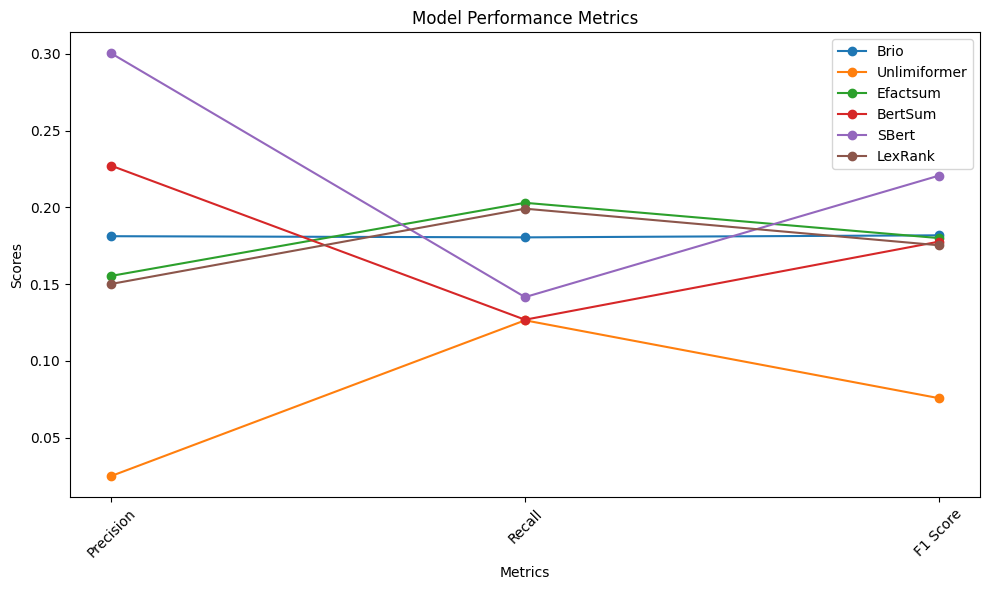

In [137]:
# The following method represents my original idea and code, since the task require this to be added.


# Plotting
plt.figure(figsize=(10, 6))

# Plotting lines for each model
for model in model_metrics_df.index:
    plt.plot(model_metrics_df.columns, model_metrics_df.loc[model], marker='o', label=model)

# Adding labels and title
plt.xlabel('Metrics')
plt.ylabel('Scores')
plt.title('Model Performance Metrics')
plt.xticks(rotation=45)
plt.legend()

plt.tight_layout()
plt.show()

**Observation:**

SBert is the best at summarizing because it's really good at picking out important information accurately. It has the highest Precision (0.30) and F1 Score (0.22), meaning it's great at getting the right details for summaries. On the other hand, Unlimiformer isn't as good, with the lowest Precision (0.03) and F1 Score (0.08), so its summaries aren't as good. Efactsum and LexRank are okay but not as good as SBert. SBert works so well because it's been trained to understand language deeply. It's like it knows the secrets of sentences, making it the best choice for making summaries.

### 5(d) Add extra functionality of your choice that is related to summarisation (for example, enable the user to choose which results to summarise; or summarise based on ratings) (10 marks).

**User can utilize both functionalities i.e. summarising based on clustered review or by rating**

Users can pick a rating and decide how many sentences they want in the summary (default: 3). We'll use SBERT because it's proven to be the best at making summaries, based on our previous findings.

**Note: This output part of the code will not be visible in the pdf as reason mentioned in the title part. Please refer the .ipynb file to the see the ouput.**

In [138]:
# The following method represents my original idea and code, since the task require this to be added.


import ipywidgets as widgets
from IPython.display import display

# Define a function to be called when the dropdown value changes
def on_change(change):
    if change['type'] == 'change' and change['name'] == 'value':
        selected_rating = dropdown_rating.value
        selected_sentences = dropdown_sentences.value

        # Filter rows based on the given rating
        filtered_df = query_result_df[query_result_df['Ratings'] == selected_rating]
        reviews = filtered_df.Reviews.tolist()
        reviews = ''.join(reviews)
        summary = sbert_model(reviews, num_sentences=selected_sentences)
        with output:
            output.clear_output()
            print(f'Selected Rating: {selected_rating}')
            print(f'Net Reviews: {reviews}')
            print(f'\nSummary: {summary}')

unique_rating = query_result_df['Ratings'].unique()
sorted_unique_rating = sorted(unique_rating)

# Create the rating dropdown widget
dropdown_rating = widgets.Dropdown(options=sorted_unique_rating, layout={'width': '30%'})

# Create the sentences dropdown widget
dropdown_sentences = widgets.Dropdown(options=[1, 2, 3, 4, 5], value=3, layout={'width': '10%'})

# Create the rating label widget
label_rating = widgets.Label('Select Rating to Summarize Reviews:', layout={'width': '18%'})

# Create the sentences label widget
label_sentences = widgets.Label('Select Summary Length (Sentences):', layout={'width': '18%'})

label_spacer = widgets.Label('', layout={'width': '5%'})

# Combine the widgets using HBox
container_rating = widgets.HBox([label_rating, dropdown_rating,label_spacer,label_sentences, dropdown_sentences])
# container_sentences = widgets.HBox([])

# # Combine the two containers vertically
# container = widgets.HBox([container_rating, container_sentences])

output = widgets.Output(layout={'width': '80%'})

# Register the function to be called when the dropdown value changes
dropdown_rating.observe(on_change)
dropdown_sentences.observe(on_change)

# Display the combined widgets and output widget
display(container_rating)
display(output)


Output(layout=Layout(width='80%'))

Choose a clustered review from the dropdown menu to display its summary.

**Note: This output part of the code will not be visible in the pdf as reason mentioned in the title part. Please refer the .ipynb file to the see the ouput.**

In [139]:
# The following method represents my original idea and code, since the task require this to be added.

# Define a function to be called when the dropdown value changes
def on_change(change):
    if change['type'] == 'change' and change['name'] == 'value':
        selected_review_text = change['new'].split('. ', 1)[1]
        summary = sbert_model(selected_review_text, num_sentences=3)
        with output_review:
            output_review.clear_output()
            print(f'\nSelected Review: {selected_review_text}')
            print(f'\nSummary: {summary}')


# Create a list of options with number and review text
options = [f"{i + 1}. {review}" for i, review in enumerate(query_result_df['Reviews'])]
# Create the dropdown widget
dropdown_review = widgets.Dropdown(options=options, description='Queries:',layout={'width': '80%'})
output_review = widgets.Output(layout={'width': '80%'})  # Set the width to 80%

# Register the function to be called when the dropdown value changes
dropdown_review.observe(on_change)

# Display the dropdown widget and output widget
display(dropdown_review)
display(output_review)


Dropdown(description='Queries:', layout=Layout(width='80%'), options=('1. I got this ring for my birthday and …

Output(layout=Layout(width='80%'))

### 5(e) Develop an interactive interface that will take a query, cluster the results, and provide summaries per cluster. Marks will be given for code efficiency. (10 marks).

**Note:**

Please scroll the result ouput to see summaries per cluster.

Feel free to enter a new query and submit it to view the result. A default value has been provided to start with.

In [140]:
# The following method represents my original idea and code, since the task require this to be added.


# Function to create a summary of topics based on reviews
def create_topic_summary(topic_reviews):
    """
    Generate a summary DataFrame for each topic based on the provided reviews.

    Parameters:
    - topic_reviews (dict): Dictionary containing reviews grouped by topic.

    Returns:
    - result_dataframe (DataFrame): DataFrame containing topic summaries.
    """
    data = {"Topic": [], "Title": [], "Summary": []}

    # Generate summaries for each topic
    for topic, reviews in topic_reviews.items():
        # Summarize the text
        summary = sbert_model(reviews, num_sentences=3)
        title = extract_title(summary)  # Extract a title for the summary
        # Append data to dictionary
        data["Topic"].append(topic)
        data["Title"].append(title)
        data["Summary"].append(summary)

    # Create DataFrame
    result_dataframe = pd.DataFrame(data)
    result_dataframe.index += 1
    return result_dataframe

**Note: This output part of the code will not be visible in the pdf as reason mentioned in the title part. Please refer the .ipynb file to the see the ouput.**

In [141]:
# The following method represents my original idea and code, since the task require this to be added.


# Function to process user query and display clustered results
def process_query(query):
    """
    Process the user query and display clustered results with summaries for each topic.

    Parameters:
    - query (str): User query string.

    """
    lda_model_user, corpus, reviews = process_user_query(query)

    df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model_user, corpus=corpus, texts=reviews)

    df_topic_sents_keywords = df_topic_sents_keywords.reset_index(drop=True)

    df_topic_sents_keywords.index += 1

    # Get lists of reviews for each topic
    topic_reviews = reviews_by_topic(df_topic_sents_keywords)

    result_dataframe = create_topic_summary(topic_reviews)

    # Display the summary results
    heading_1 = "<p style='font-size:40px; text-align:center;'>Clustered Results</p>"
    heading_2 = "<p style='font-size:40px; text-align:center; maring-top:40px'>Summaries Each Cluster</p>"

    with output_box:
        display(HTML(heading_1))
        display(HTML(df_topic_sents_keywords.to_html()))
        display(HTML(heading_2))
        display(HTML(result_dataframe.to_html()))


default_value = '''Item was great quality and came promptly. I'm very happy with it and recommend it unreservedly.'''

# Text input widget for user query
query_text = widgets.Text(description="Enter Query:", value=default_value, layout=widgets.Layout(width='50%'))

# Button widget to trigger query processing
query_button = widgets.Button(description="Search")

# Output widget to display clustered sentences
output_box = widgets.Output(layout=Layout(width='90%'))

# Call process_query with default value to invoke it for the first time
process_query(default_value)

# Define callback function for button click event
def on_button_click(b):
    """
    Callback function for button click event.

    Parameters:
    - b: Button object representing the button clicked.

    Returns:
    - None
    """
    output_box.clear_output(wait=True)
    query = query_text.value.strip()  # Get the query entered by the user
    process_query(query)  # Process the query

# Link button click event to the callback function
query_button.on_click(on_button_click)

# Arrange query box, submit button, and output box using VBox and HBox layouts
query_box = widgets.HBox([query_text, query_button])
display(widgets.VBox([query_box, output_box]))




# Submission Information

In [179]:
!ls "/content/drive/My Drive/Colab Notebooks"

 21COP509   COP509cw_F316169.ipynb  'Copy of COP509cw.ipynb'   test.ipynb
 COP509cw   COP509cw_F316169.pdf     test.html


In [167]:
!jupyter nbconvert --to html '/content/drive/My Drive/Colab Notebooks/COP509cw_F316169.ipynb' &> /dev/null